# Multi-Momentum Particle Identification Analysis

A comprehensive machine learning framework for particle identification (PID) in high-energy physics experiments using XGBoost, Deep Neural Networks (DNN), LightGBM, and ensemble methods across multiple momentum ranges.

## Overview

This repository implements advanced particle identification techniques with momentum-dependent classification models. The analysis covers five particle species (Pion, Kaon, Proton, and Electron) across four distinct momentum ranges, enabling detailed investigation of detector performance characteristics.

### Key Features

- **Triple Machine Learning Approaches**: Combines gradient boosting (XGBoost), deep learning (DNN) and LigthGBM for optimal performance  
- **Ensemble Methods**: Weighted voting system that intelligently combines model predictions for enhanced accuracy  
- **Automated Hyperparameter Optimisation**: Uses Optuna for all model families (XGBoost, DNN, LigthGBM)  
- **Persistent Model Caching**: Trains once, loads instantly on subsequent runs  
- **Multi-Momentum Analysis**: Separate models for full spectrum, low (0.1–1 GeV/c), mid (1–3 GeV/c), and high (3+ GeV/c) momentum ranges  
- **Comprehensive Visualisations**: ROC curves, confusion matrices, output distributions, and feature importance analysis

The pipeline is adaptable for multi-momentum PID classification, allowing robust particle identification across different particle kinematics regions using an interpretable and extensible model ensemble.


In [ ]:
# import os
# import signal

# pid = os.getpid()
# print(f"Killing kernel with PID: {pid}")
# os.kill(pid, signal.SIGTERM)

In [1]:
!pip install optuna -q

In [2]:
# !pip install hipe4ml
!pip install 'numpy<2.0' 'scipy>=1.15,<1.16' hipe4ml -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 12.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 392.4/392.4 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 6.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.0/908.0 kB 24.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 653.6/653.6 kB 19.5 MB/s eta 0:00:00


In [3]:
# ============================================================================
# IMPORTS & LIBRARY CONFIGURATION
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle
import pickle
import os
import json
import lightgbm as lgb

from hipe4ml.model_handler import ModelHandler
from hipe4ml import plot_utils

import xgboost as xgb
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, classification_report
from sklearn.utils.class_weight import compute_class_weight

from tqdm import tqdm

# ============================================================================
# GPU CONFIGURATION - Force GPU if available, fallback to CPU
# ============================================================================

# Suppress non-critical TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping

# Configure GPU
gpus = tf.config.list_physical_devices('GPU')
print(f"\nFound {len(gpus)} GPU(s)")

if gpus:
    try:
        # Enable memory growth to avoid OOM errors
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        
        # Force TensorFlow to use GPU
        tf.config.set_visible_devices(gpus, 'GPU')
        print(f"✓ GPU Mode ENABLED - Using {len(gpus)} GPU(s)")
        print(f"  GPUs: {[gpu.name for gpu in gpus]}")
        
        DEVICE_MODE = 'GPU'
    except RuntimeError as e:
        print(f"✗ GPU initialization failed: {e}")
        print("Falling back to CPU...")
        tf.config.set_visible_devices([], 'GPU')
        DEVICE_MODE = 'CPU'
else:
    print("✓ No GPU found - Using CPU mode by default")
    DEVICE_MODE = 'CPU'

print(f"Device Mode: {DEVICE_MODE}\n")

# ============================================================================
# REMAINING IMPORTS
# ============================================================================

import ipywidgets as widgets
from IPython.display import display, clear_output

# Note: Kaggle environment - no need for drive.mount()
# Removed: from google.colab import drive

print("✓ All libraries imported successfully")

2025-11-12 19:05:37.496700: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762974337.935511      39 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762974338.040337      39 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered



Found 0 GPU(s)
✓ No GPU found - Using CPU mode by default
Device Mode: CPU

✓ All libraries imported successfully


2025-11-12 19:05:58.100357: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## SECTION 1: Configuration
### Define Momentum Ranges, Particles & Storage Paths

In [4]:
print("="*80)
print("SECTION 1: CONFIGURATION")
print("="*80)

BASE_DIR = '/kaggle/working/'
CSV_FILE_PATH = '/kaggle/input/pid-features/pid_features_large.csv'  # ← UPDATE dataset name

# ✓ KEEP THESE - Your momentum ranges and particle names
MOMENTUM_RANGES = {
    'full': {'name': 'All Data (full spectrum)', 'min': 0.0,  'max': 999, 'color': '#9333EA'},
    'low':  {'name': '0.1-1 GeV/c',           'min': 0.1, 'max': 1.0,  'color': '#3B82F6'},
    'mid':  {'name': '1-3 GeV/c',            'min': 1.0, 'max': 3.0,  'color': '#F59E0B'},
    'high': {'name': '3+ GeV/c',             'min': 3.0, 'max': 999,  'color': '#22C55E'}
}

PARTICLE_NAMES = ['Pion', 'Kaon', 'Proton', 'Electron']

# Storage directories
MODEL_SAVE_DIR = os.path.join(BASE_DIR, 'XGBoost/')
DNN_SAVE_DIR = os.path.join(BASE_DIR, 'DNN/')
OPTUNA_SAVE_DIR = os.path.join(BASE_DIR, 'Optuna_Studies/')
ENSEMBLE_SAVE_DIR = os.path.join(BASE_DIR, 'Ensemble/')

for directory in [MODEL_SAVE_DIR, DNN_SAVE_DIR, OPTUNA_SAVE_DIR, ENSEMBLE_SAVE_DIR]:
    os.makedirs(directory, exist_ok=True)

# Force retraining flags
FORCE_REOPTIMIZE_XGB = False
FORCE_REOPTIMIZE_DNN = False
FORCE_REOPTIMIZE_TABNET = False
FORCE_RETRAIN_XGB = False
FORCE_RETRAIN_DNN = False
FORCE_RETRAIN_TABNET = False

print("✓ Configuration loaded")
print(f"  Momentum ranges: {list(MOMENTUM_RANGES.keys())}")
print(f"  Particle species: {PARTICLE_NAMES}")
print(f"  Base storage: {BASE_DIR}")

SECTION 1: CONFIGURATION
✓ Configuration loaded
  Momentum ranges: ['full', 'low', 'mid', 'high']
  Particle species: ['Pion', 'Kaon', 'Proton', 'Electron']
  Base storage: /kaggle/working/


### Save/Load Functions

In [5]:
# ============================================================================
# SAVE/LOAD FUNCTIONS FOR ALL MODELS
# ============================================================================

INPUT_DATASET_DIR = '/kaggle/input/pid-models/'
WORKING_DIR = '/kaggle/working/'

def save_xgboost_model(range_key, model_info, dataset_info):
    save_path = os.path.join(WORKING_DIR, 'XGBoost', f'xgb_model_{range_key}.pkl')
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    save_data = {
        'model': model_info['model'],
        'features': available_features,
        'config': model_info['config'],
        'train_acc': model_info['train_acc'],
        'test_acc': model_info['test_acc'],
        'n_train': dataset_info['n_train'],
        'n_test': dataset_info['n_test']
    }
    with open(save_path, 'wb') as f:
        pickle.dump(save_data, f)
    print(f"[SAVE] XGBoost model saved to: {save_path}")

def load_xgboost_model(range_key):
    load_path = os.path.join(WORKING_DIR, 'XGBoost', f'xgb_model_{range_key}.pkl')
    if os.path.exists(load_path):
        print(f"[LOAD] Loading XGBoost model from working directory: {load_path}")
    else:
        load_path = os.path.join(INPUT_DATASET_DIR, 'XGBoost', f'xgb_model_{range_key}.pkl')
        if os.path.exists(load_path):
            print(f"[LOAD] Loading XGBoost model from input dataset: {load_path}")
        else:
            print(f"[LOAD] XGBoost model for range '{range_key}' NOT FOUND")
            return None
    with open(load_path, 'rb') as f:
        save_data = pickle.load(f)
    return {
        'model': save_data['model'],
        'config': save_data['config'],
        'train_acc': save_data['train_acc'],
        'test_acc': save_data['test_acc']
    }

def save_lightgbm_model(range_key, model_info, dataset_info):
    save_path = os.path.join(WORKING_DIR, 'LightGBM', f'lgb_model_{range_key}.pkl')
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    save_data = {
        'model': model_info['model'],
        'features': available_features,
        'config': model_info['config'],
        'train_acc': model_info['train_acc'],
        'test_acc': model_info['test_acc'],
        'n_train': dataset_info['n_train'],
        'n_test': dataset_info['n_test']
    }
    with open(save_path, 'wb') as f:
        pickle.dump(save_data, f)
    print(f"[SAVE] LightGBM model saved to: {save_path}")

def load_lightgbm_model(range_key):
    load_path = os.path.join(WORKING_DIR, 'LightGBM', f'lgb_model_{range_key}.pkl')
    if os.path.exists(load_path):
        print(f"[LOAD] Loading LightGBM model from working directory: {load_path}")
    else:
        load_path = os.path.join(INPUT_DATASET_DIR, 'LightGBM', f'lgb_model_{range_key}.pkl')
        if os.path.exists(load_path):
            print(f"[LOAD] Loading LightGBM model from input dataset: {load_path}")
        else:
            print(f"[LOAD] LightGBM model for range '{range_key}' NOT FOUND")
            return None
    with open(load_path, 'rb') as f:
        save_data = pickle.load(f)
    return {
        'model': save_data['model'],
        'config': save_data['config'],
        'train_acc': save_data['train_acc'],
        'test_acc': save_data['test_acc']
    }

def save_dnn_model(range_key, dnn_model, scaler, metrics_dict):
    model_path = os.path.join(WORKING_DIR, 'DNN', f'dnn_model_{range_key}.keras')
    os.makedirs(os.path.dirname(model_path), exist_ok=True)
    dnn_model.save(model_path)
    scaler_path = os.path.join(WORKING_DIR, 'DNN', f'dnn_scaler_{range_key}.pkl')
    with open(scaler_path, 'wb') as f:
        pickle.dump(scaler, f)
    metrics_path = os.path.join(WORKING_DIR, 'DNN', f'dnn_metrics_{range_key}.json')
    with open(metrics_path, 'w') as f:
        json.dump(metrics_dict, f)
    print(f"[SAVE] DNN model saved to: {model_path}")

def load_dnn_model(range_key):
    model_path_working = os.path.join(WORKING_DIR, 'DNN', f'dnn_model_{range_key}.keras')
    model_path_input = os.path.join('/kaggle/input/pid-models/DNN', f'dnn_model_{range_key}.keras')

    if os.path.exists(model_path_working):
        model_path = model_path_working
        scaler_path = os.path.join(WORKING_DIR, 'DNN', f'dnn_scaler_{range_key}.pkl')
        metrics_path = os.path.join(WORKING_DIR, 'DNN', f'dnn_metrics_{range_key}.json')
    elif os.path.exists(model_path_input):
        model_path = model_path_input
        scaler_path = os.path.join('/kaggle/input/pid-models/DNN', f'dnn_scaler_{range_key}.pkl')
        metrics_path = os.path.join('/kaggle/input/pid-models/DNN', f'dnn_metrics_{range_key}.json')
    else:
        print(f"[LOAD] DNN model for range '{range_key}' NOT FOUND")
        return None

    dnn_model = keras.models.load_model(model_path)
    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)
    with open(metrics_path, 'r') as f:
        metrics = json.load(f)
    return {'model': dnn_model, 'scaler': scaler, 'metrics': metrics}

print("✓ Save/Load functions defined (XGBoost, LightGBM, DNN only)")

✓ Save/Load functions defined (XGBoost, LightGBM, DNN only)


## SECTION 2: Data Loading & Cleaning
### Load CSV & Prepare Features

In [6]:
print("\n" + "="*80)
print("SECTION 2: DATA LOADING & CLEANING")
print("="*80)

csv_file_path = '/kaggle/input/pid-features/pid_features_large.csv'  # ← UPDATE dataset name

try:
    print(f"Loading CSV from: {csv_file_path}")
    df_iter = pd.read_csv(csv_file_path, dtype='float32', chunksize=500_000, low_memory=False)
    df = pd.concat(df_iter, ignore_index=True)
    print(f"✓ Loaded: {df.shape}")
except FileNotFoundError:
    print(f"✗ Error: CSV file not found at {csv_file_path}")
    print("Please update CSV_FILE_PATH with correct Kaggle dataset path")
    raise

# Clean data
df.replace(-999, np.nan, inplace=True)

# Define feature groups
tof_features = [col for col in df.columns if 'tof' in col.lower()]
tpc_features = [col for col in df.columns if 'tpc' in col.lower()]
bayes_features = [col for col in df.columns if 'bayes_prob' in col.lower()]

# Fill missing values for each feature group
df[tof_features] = df[tof_features].fillna(0)
df[tpc_features] = df[tpc_features].fillna(0)
df[bayes_features] = df[bayes_features].fillna(0)

# Create indicator features
df['has_tof'] = (df[tof_features].abs().sum(axis=1) > 0).astype(int)
df['has_tpc'] = (df[tpc_features].abs().sum(axis=1) > 0).astype(int)

# Drop rows missing critical features
df.dropna(subset=['pt', 'eta', 'mc_pdg'], inplace=True)
print(f"✓ Cleaned: {df.shape}")

# PDG mapping
def pdg_to_species(pdg):
    ap = abs(int(pdg))
    if ap == 211:          return 0
    elif ap == 321:        return 1
    elif ap == 2212:       return 2
    elif ap == 11:         return 3
    else: return -1

df['particle_species'] = df['mc_pdg'].apply(pdg_to_species)
df = df[df['particle_species'] >= 0].reset_index(drop=True)

# Feature engineering
for feature in ['pt', 'p', 'tpc_signal', 'tof_beta']:
    if feature in df.columns:
        df[feature] = np.log1p(df[feature].abs())

# Define all training features
training_features = [
    'pt', 'eta', 'phi',
    'tpc_signal', 'tpc_nsigma_pi', 'tpc_nsigma_ka', 'tpc_nsigma_pr', 'tpc_nsigma_el',
    'tof_beta', 'tof_nsigma_pi', 'tof_nsigma_ka', 'tof_nsigma_pr', 'tof_nsigma_el',
    'bayes_prob_pi', 'bayes_prob_ka', 'bayes_prob_pr', 'bayes_prob_el',
    'dca_xy', 'dca_z', 'has_tpc', 'has_tof'
]
available_features = [f for f in training_features if f in df.columns]
print(f"✓ Features: {len(available_features)}")

# Verify no missing values in final dataset
missing_count = df[available_features].isnull().sum().sum()
if missing_count > 0:
    print(f"⚠ Warning: {missing_count} missing values found in features, dropping rows with NaNs")
    df = df.dropna(subset=available_features)
else:
    print(f"✓ No missing values in training features")

print(f"✓ Final dataset: {df.shape}")
print(f"✓ Available features: {available_features}")


SECTION 2: DATA LOADING & CLEANING
Loading CSV from: /kaggle/input/pid-features/pid_features_large.csv
✓ Loaded: (4729393, 37)
✓ Cleaned: (4729392, 37)
✓ Features: 21
✓ No missing values in training features
✓ Final dataset: (4163954, 38)
✓ Available features: ['pt', 'eta', 'phi', 'tpc_signal', 'tpc_nsigma_pi', 'tpc_nsigma_ka', 'tpc_nsigma_pr', 'tpc_nsigma_el', 'tof_beta', 'tof_nsigma_pi', 'tof_nsigma_ka', 'tof_nsigma_pr', 'tof_nsigma_el', 'bayes_prob_pi', 'bayes_prob_ka', 'bayes_prob_pr', 'bayes_prob_el', 'dca_xy', 'dca_z', 'has_tpc', 'has_tof']


## SECTION 3: Momentum Range Splitting
### Prepare 4 Independent Datasets

In [7]:
print("\n" + "="*80)
print("SECTION 3: MOMENTUM RANGE SPLITTING")
print("="*80)

momentum_datasets = {}

for range_key, range_config in MOMENTUM_RANGES.items():
    print(f"\n{range_config['name']}")
    df_range = df[(df['pt'] >= range_config['min']) & (df['pt'] < range_config['max'])].copy()
    print(f"   Tracks: {len(df_range):,}")

    if len(df_range) == 0 or df_range['particle_species'].value_counts().min() < 10:
        continue

    X = df_range[available_features].astype('float32')
    y = df_range['particle_species']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=available_features).astype('float32')

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)
    X_train, X_test = X_train.reset_index(drop=True), X_test.reset_index(drop=True)
    y_train, y_test = pd.Series(y_train.values), pd.Series(y_test.values)

    momentum_datasets[range_key] = {
        'config': range_config,
        'X_train': X_train, 'X_test': X_test,
        'y_train': y_train, 'y_test': y_test,
        'scaler': scaler,
        'n_train': len(X_train), 'n_test': len(X_test)
    }
    print(f"   Train: {len(X_train):,}, Test: {len(X_test):,}")

print(f"\n✓ Prepared {len(momentum_datasets)} ranges")


SECTION 3: MOMENTUM RANGE SPLITTING

All Data (full spectrum)
   Tracks: 4,163,954
   Train: 2,914,767, Test: 1,249,187

0.1-1 GeV/c
   Tracks: 3,956,919
   Train: 2,769,843, Test: 1,187,076

1-3 GeV/c
   Tracks: 128,035
   Train: 89,624, Test: 38,411

3+ GeV/c
   Tracks: 157
   Train: 109, Test: 48

✓ Prepared 4 ranges


## SECTION 4: Optuna Hyperparameter Optimisation
### Optimise XGBoost Parameters (with Auto-Load & Save)

In [13]:
print("\n" + "="*80)
print("SECTION 4: OPTUNA OPTIMISATION FOR XGBOOST")
print("="*80)

optuna_studies_xgb = {}
FORCE_REOPTIMIZE_XGB = False

input_optuna_dir = '/kaggle/input/pid-models/Optuna_Studies'
local_optuna_dir = OPTUNA_SAVE_DIR

for range_key, dataset in momentum_datasets.items():
    config = dataset['config']
    print(f"\n{'='*70}")
    print(f"Processing XGBoost Optuna: {config['name']}")

    study_path_input = os.path.join(input_optuna_dir, f'optuna_study_xgb_{range_key}.pkl')
    study_path_local = os.path.join(local_optuna_dir, f'optuna_study_xgb_{range_key}.pkl')

    loaded_study = None
    if os.path.exists(study_path_input) and not FORCE_REOPTIMIZE_XGB:
        print(f"Loading saved XGBoost study from Kaggle input dataset: {study_path_input}")
        with open(study_path_input, 'rb') as f:
            loaded_study = pickle.load(f)
    elif os.path.exists(study_path_local) and not FORCE_REOPTIMIZE_XGB:
        print(f"Loading saved XGBoost study from local working directory: {study_path_local}")
        with open(study_path_local, 'rb') as f:
            loaded_study = pickle.load(f)

    if loaded_study is not None:
        optuna_studies_xgb[range_key] = loaded_study
        print(f"   Best ROC-AUC: {loaded_study.best_value:.4f}")
        continue

    print(f"No saved study found, running XGBoost optimisation...")

    X_train_optuna = dataset['X_train'].sample(min(300_000, len(dataset['X_train'])), random_state=42)
    y_train_optuna = dataset['y_train'].loc[X_train_optuna.index]

    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 200, 800, step=100),
            'max_depth': trial.suggest_int('max_depth', 4, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'gamma': trial.suggest_float('gamma', 0.0, 1.0)
        }
        model = xgb.XGBClassifier(**params, random_state=42, n_jobs=-1, tree_method='hist')
        model.fit(X_train_optuna, y_train_optuna)
        y_pred = model.predict_proba(dataset['X_test'])
        return roc_auc_score(dataset['y_test'], y_pred, multi_class='ovo', average='weighted')

    study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
    study.optimize(objective, n_trials=20, show_progress_bar=True)
    optuna_studies_xgb[range_key] = study

    save_path = os.path.join(local_optuna_dir, f'optuna_study_xgb_{range_key}.pkl')
    with open(save_path, 'wb') as f:
        pickle.dump(study, f)
    print(f"   Saved new study to: {save_path}")
    print(f"   Best ROC-AUC: {study.best_value:.4f}")

print("\nOptuna XGBoost optimisation complete")


SECTION 4: OPTUNA OPTIMISATION FOR XGBOOST

Processing XGBoost Optuna: All Data (full spectrum)
Loading saved XGBoost study from Kaggle input dataset: /kaggle/input/pid-models/Optuna_Studies/optuna_study_xgb_full.pkl
   Best ROC-AUC: 0.9384

Processing XGBoost Optuna: 0.1-1 GeV/c
Loading saved XGBoost study from Kaggle input dataset: /kaggle/input/pid-models/Optuna_Studies/optuna_study_xgb_low.pkl
   Best ROC-AUC: 0.9410

Processing XGBoost Optuna: 1-3 GeV/c
Loading saved XGBoost study from Kaggle input dataset: /kaggle/input/pid-models/Optuna_Studies/optuna_study_xgb_mid.pkl
   Best ROC-AUC: 0.8430

Processing XGBoost Optuna: 3+ GeV/c
Loading saved XGBoost study from Kaggle input dataset: /kaggle/input/pid-models/Optuna_Studies/optuna_study_xgb_high.pkl
   Best ROC-AUC: 0.6954

Optuna XGBoost optimisation complete


## SECTION 4B: Optuna Hyperparameter Optimisation for DNN
### Optimise Neural Network Architecture & Hyperparameters (with Auto-Load & Save)

In [14]:
# ============================================================================
# SECTION 4B: OPTUNA OPTIMISATION FOR DNN (WITH CLASS WEIGHTS)
# ============================================================================

print("\n" + "="*80)
print("SECTION 4B: OPTUNA OPTIMISATION FOR DNN")
print("Mode: CPU (to avoid cuDNN issues)")
print("="*80)

FIXED_SEED = 42
RANDOM_SEED = np.random.randint(0, 1_000_000)
seed = RANDOM_SEED

input_optuna_dir = '/kaggle/input/pid-models/Optuna_Studies'
local_optuna_dir = OPTUNA_SAVE_DIR

with tf.device('/CPU:0'):
    optuna_studies_dnn = {}
    FORCE_REOPTIMIZE_DNN = False

    for range_key, dataset in momentum_datasets.items():
        config = dataset['config']
        print(f"\n{'='*70}")
        print(f"Processing DNN Optuna: {config['name']}")

        study_path_input = os.path.join(input_optuna_dir, f'optuna_study_dnn_{range_key}.pkl')
        study_path_local = os.path.join(local_optuna_dir, f'optuna_study_dnn_{range_key}.pkl')

        loaded_study = None
        if os.path.exists(study_path_input) and not FORCE_REOPTIMIZE_DNN:
            print(f"Loading saved DNN study from Kaggle input dataset: {study_path_input}")
            with open(study_path_input, 'rb') as f:
                loaded_study = pickle.load(f)
        elif os.path.exists(study_path_local) and not FORCE_REOPTIMIZE_DNN:
            print(f"Loading saved DNN study from local working directory: {study_path_local}")
            with open(study_path_local, 'rb') as f:
                loaded_study = pickle.load(f)

        if loaded_study is not None:
            optuna_studies_dnn[range_key] = loaded_study
            print(f"   Best validation accuracy: {loaded_study.best_value:.4f}")
            continue

        print(f"Running DNN optimisation (CPU Mode)...")
        
        # Prepare data for optimization
        X_train_optuna = dataset['X_train'].sample(min(200_000, len(dataset['X_train'])), random_state=seed)
        y_train_optuna = dataset['y_train'].loc[X_train_optuna.index]

        X_tr, X_val, y_tr, y_val = train_test_split(
            X_train_optuna, y_train_optuna, test_size=0.2, random_state=seed, stratify=y_train_optuna
        )

        # ====================================================================
        # Compute class weights for training data
        # ====================================================================
        class_weights = compute_class_weight(
            'balanced',
            classes=np.unique(y_tr.values),
            y=y_tr.values
        )
        class_weights_dict = dict(enumerate(class_weights))
        print(f"   Class weights: {class_weights_dict}")

        # Scale features for optimization
        scaler_optuna = StandardScaler()
        X_tr_scaled = scaler_optuna.fit_transform(X_tr.values)
        X_val_scaled = scaler_optuna.transform(X_val.values)

        def objective_dnn(trial):
            try:
                n_layers = trial.suggest_int('n_layers', 2, 4)
                units_layer_1 = trial.suggest_categorical('units_layer_1', [128, 256, 512])
                units_layer_2 = trial.suggest_categorical('units_layer_2', [64, 128, 256])
                units_layer_3 = trial.suggest_categorical('units_layer_3', [32, 64, 128])
                dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
                learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
                batch_size = trial.suggest_categorical('batch_size', [128, 256, 512])
                l2_reg = trial.suggest_float('l2_reg', 1e-5, 1e-2, log=True)

                model = keras.Sequential()
                model.add(layers.Input(shape=(len(available_features),)))
                model.add(layers.Dense(units_layer_1, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)))
                model.add(layers.BatchNormalization())
                model.add(layers.Dropout(dropout_rate))
                model.add(layers.Dense(units_layer_2, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)))
                model.add(layers.BatchNormalization())
                model.add(layers.Dropout(dropout_rate))

                if n_layers >= 3:
                    model.add(layers.Dense(units_layer_3, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)))
                    model.add(layers.BatchNormalization())
                    model.add(layers.Dropout(dropout_rate * 0.7))

                if n_layers >= 4:
                    model.add(layers.Dense(32, activation='relu'))
                    model.add(layers.Dropout(dropout_rate * 0.5))

                model.add(layers.Dense(len(PARTICLE_NAMES), activation='softmax'))
                model.compile(
                    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy']
                )

                early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
                
                # ============================================================
                # Train with class weights
                # ============================================================
                history = model.fit(
                    X_tr_scaled, y_tr.values,
                    validation_data=(X_val_scaled, y_val.values),
                    batch_size=batch_size,
                    epochs=30,
                    callbacks=[early_stop],
                    class_weight=class_weights_dict,  # ← KEY: CLASS WEIGHTS
                    verbose=0
                )

                return max(history.history['val_accuracy'])

            except Exception as e:
                print(f"   Trial failed: {str(e)[:50]}")
                return 0.0

        study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed))
        study.optimize(objective_dnn, n_trials=20, show_progress_bar=True)
        optuna_studies_dnn[range_key] = study

        save_path = os.path.join(local_optuna_dir, f'optuna_study_dnn_{range_key}.pkl')
        with open(save_path, 'wb') as f:
            pickle.dump(study, f)
        
        print(f"   Saved study to: {save_path}")
        print(f"   Best validation accuracy: {study.best_value:.4f}")
        print(f"   Best hyperparameters: {study.best_params}")

print("\n✓ DNN optimisation complete")


SECTION 4B: OPTUNA OPTIMISATION FOR DNN
Mode: CPU (to avoid cuDNN issues)

Processing DNN Optuna: All Data (full spectrum)
Loading saved DNN study from Kaggle input dataset: /kaggle/input/pid-models/Optuna_Studies/optuna_study_dnn_full.pkl
   Best validation accuracy: 0.7041

Processing DNN Optuna: 0.1-1 GeV/c
Loading saved DNN study from Kaggle input dataset: /kaggle/input/pid-models/Optuna_Studies/optuna_study_dnn_low.pkl
   Best validation accuracy: 0.7200

Processing DNN Optuna: 1-3 GeV/c
Loading saved DNN study from Kaggle input dataset: /kaggle/input/pid-models/Optuna_Studies/optuna_study_dnn_mid.pkl
   Best validation accuracy: 0.6526

Processing DNN Optuna: 3+ GeV/c
Loading saved DNN study from Kaggle input dataset: /kaggle/input/pid-models/Optuna_Studies/optuna_study_dnn_high.pkl
   Best validation accuracy: 0.6818

✓ DNN optimisation complete


## SECTION 4C: Optuna Hyperparameter Optimisation for LightGBM
### Optimise LightGBM Hyperparameters (with Auto-Load & Save)

In [15]:
print("\n" + "="*80)
print("SECTION 4D: OPTUNA OPTIMISATION FOR LIGHTGBM")
print("="*80)

optuna_studies_lgb = {}
FORCE_REOPTIMIZE_LGB = False

input_optuna_dir = '/kaggle/input/pid-models/Optuna_Studies'
local_optuna_dir = OPTUNA_SAVE_DIR

for range_key, dataset in momentum_datasets.items():
    config = dataset['config']
    print(f"\n{'='*70}")
    print(f"Processing LightGBM Optuna: {config['name']}")

    study_path_input = os.path.join(input_optuna_dir, f'optuna_study_lgb_{range_key}.pkl')
    study_path_local = os.path.join(local_optuna_dir, f'optuna_study_lgb_{range_key}.pkl')

    loaded_study = None
    if os.path.exists(study_path_input) and not FORCE_REOPTIMIZE_LGB:
        print(f"Loading saved LightGBM study from Kaggle input dataset: {study_path_input}")
        with open(study_path_input, 'rb') as f:
            loaded_study = pickle.load(f)
    elif os.path.exists(study_path_local) and not FORCE_REOPTIMIZE_LGB:
        print(f"Loading saved LightGBM study from working directory: {study_path_local}")
        with open(study_path_local, 'rb') as f:
            loaded_study = pickle.load(f)

    if loaded_study is not None:
        optuna_studies_lgb[range_key] = loaded_study
        print(f"   Best ROC-AUC: {loaded_study.best_value:.4f}")
        continue

    print(f"Running LightGBM optimisation...")

    X_train_optuna = dataset['X_train'].sample(min(300_000, len(dataset['X_train'])), random_state=42)
    y_train_optuna = dataset['y_train'].loc[X_train_optuna.index]

    def objective_lgb(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 200, 800, step=100),
            'max_depth': trial.suggest_int('max_depth', 4, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100)
        }
        model = lgb.LGBMClassifier(**params, random_state=42, n_jobs=-1, verbose=-1)
        model.fit(X_train_optuna, y_train_optuna)
        y_pred = model.predict_proba(dataset['X_test'])
        return roc_auc_score(dataset['y_test'], y_pred, multi_class='ovo', average='weighted')

    study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
    study.optimize(objective_lgb, n_trials=20, show_progress_bar=True)
    optuna_studies_lgb[range_key] = study

    with open(study_path_local, 'wb') as f:
        pickle.dump(study, f)

    print(f"   Saved study to: {study_path_local}")
    print(f"   Best ROC-AUC: {study.best_value:.4f}")

print("\n✓ LightGBM optimisation complete")


SECTION 4D: OPTUNA OPTIMISATION FOR LIGHTGBM

Processing LightGBM Optuna: All Data (full spectrum)
Loading saved LightGBM study from Kaggle input dataset: /kaggle/input/pid-models/Optuna_Studies/optuna_study_lgb_full.pkl
   Best ROC-AUC: 0.9379

Processing LightGBM Optuna: 0.1-1 GeV/c
Loading saved LightGBM study from Kaggle input dataset: /kaggle/input/pid-models/Optuna_Studies/optuna_study_lgb_low.pkl
   Best ROC-AUC: 0.9407

Processing LightGBM Optuna: 1-3 GeV/c
Loading saved LightGBM study from Kaggle input dataset: /kaggle/input/pid-models/Optuna_Studies/optuna_study_lgb_mid.pkl
   Best ROC-AUC: 0.8432

Processing LightGBM Optuna: 3+ GeV/c
Loading saved LightGBM study from Kaggle input dataset: /kaggle/input/pid-models/Optuna_Studies/optuna_study_lgb_high.pkl
   Best ROC-AUC: 0.7249

✓ LightGBM optimisation complete


## SECTION 5: XGBoost Model Training
### Train with Auto-Save & Load

In [16]:
# ============================================================================
# SECTION 6B: XGBOOST MODEL TRAINING - ALL MOMENTUM RANGES
# ============================================================================

print("\n" + "="*80)
print("SECTION 6B: XGBOOST MODEL TRAINING")
print("="*80)

trained_xgb_models = {}
FORCE_RETRAIN_XGBOOST = False

momentum_list = list(momentum_datasets.items())

for range_key, dataset in tqdm(momentum_list, desc="Training XGBoost models"):
    config = dataset['config']
    print(f"\n{'='*70}")
    print(f"XGBoost: {config['name']}")

    loaded = None
    if not FORCE_RETRAIN_XGBOOST:
        loaded = load_xgboost_model(range_key)
        
        if loaded:
            trained_xgb_models[range_key] = {
                'model': loaded['model'],
                'train_acc': loaded['train_acc'],
                'test_acc': loaded['test_acc'],
                'config': config
            }
            print(f"✓ Loaded successfully! Train Acc: {loaded['train_acc']:.4f}, Test Acc: {loaded['test_acc']:.4f}")
            continue
        else:
            print(f"No saved model found, training for range '{range_key}'...")

    print(f"Training XGBoost...")
    print(f"  Training samples: {len(dataset['X_train']):,}")
    print(f"  Test samples: {len(dataset['X_test']):,}")

    model_xgb = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=7,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        eval_metric='logloss'
    )

    model_xgb.fit(
        dataset['X_train'].values.astype(np.float32),
        dataset['y_train'].values.astype(np.int64),
        eval_set=[(dataset['X_test'].values.astype(np.float32), dataset['y_test'].values.astype(np.int64))],
        verbose=False
    )

    train_pred = model_xgb.predict(dataset['X_train'].values.astype(np.float32))
    test_pred = model_xgb.predict(dataset['X_test'].values.astype(np.float32))

    train_acc = np.mean(train_pred == dataset['y_train'].values)
    test_acc = np.mean(test_pred == dataset['y_test'].values)

    trained_xgb_models[range_key] = {
        'model': model_xgb,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'config': config
    }

    print(f"  Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")
    print(f"  [SAVE] Saving XGBoost model for range '{range_key}'...")
    
    try:
        save_xgboost_model(range_key, {'model': model_xgb, 'config': config, 'train_acc': train_acc, 'test_acc': test_acc}, 
                          {'n_train': len(dataset['X_train']), 'n_test': len(dataset['X_test'])})
        print(f"  [SAVE] ✓ Model saved successfully!")
    except Exception as e:
        print(f"  [SAVE] ✗ Error saving model: {str(e)[:80]}")

print(f"\n✓ XGBoost training complete")


SECTION 6B: XGBOOST MODEL TRAINING


Training XGBoost models:   0%|          | 0/4 [00:00<?, ?it/s]


XGBoost: All Data (full spectrum)
[LOAD] Loading XGBoost model from input dataset: /kaggle/input/pid-models/XGBoost/xgb_model_full.pkl


Training XGBoost models:  25%|██▌       | 1/4 [00:00<00:02,  1.12it/s]

✓ Loaded successfully! Train Acc: 0.8705, Test Acc: 0.8675

XGBoost: 0.1-1 GeV/c
[LOAD] Loading XGBoost model from input dataset: /kaggle/input/pid-models/XGBoost/xgb_model_low.pkl


Training XGBoost models: 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]

✓ Loaded successfully! Train Acc: 0.8769, Test Acc: 0.8741

XGBoost: 1-3 GeV/c
[LOAD] Loading XGBoost model from input dataset: /kaggle/input/pid-models/XGBoost/xgb_model_mid.pkl
✓ Loaded successfully! Train Acc: 0.7554, Test Acc: 0.7470

XGBoost: 3+ GeV/c
[LOAD] Loading XGBoost model from input dataset: /kaggle/input/pid-models/XGBoost/xgb_model_high.pkl
✓ Loaded successfully! Train Acc: 0.8899, Test Acc: 0.6667

✓ XGBoost training complete


## SECTION 6: Deep Neural Network Training
### Build & Train DNN Models with Auto-Save & Load

In [17]:
# ============================================================================
# SECTION 6: DNN MODEL TRAINING (WITH CLASS WEIGHTS AND OPTUNA HYPERPARAMS)
# ============================================================================

print("\n" + "="*80)
print("SECTION 6D: DNN MODEL TRAINING (WITH CLASS WEIGHTS)")
print("="*80)

trained_dnn_models = {}
FORCE_RETRAIN_DNN = False

momentum_list = list(momentum_datasets.items())

for range_key, dataset in tqdm(momentum_list, desc="Training DNN models"):
    config = dataset['config']
    print(f"\n{'='*70}")
    print(f"DNN: {config['name']}")

    loaded = None
    if not FORCE_RETRAIN_DNN:
        loaded = load_dnn_model(range_key)
        
        if loaded:
            trained_dnn_models[range_key] = {
                'model': loaded['model'],
                'scaler': loaded['scaler'],
                'train_acc': loaded['metrics']['train_acc'],
                'test_acc': loaded['metrics']['test_acc'],
                'config': config
            }
            print(f"✓ Loaded successfully! Train Acc: {loaded['metrics']['train_acc']:.4f}, Test Acc: {loaded['metrics']['test_acc']:.4f}")
            continue
        else:
            print(f"No saved model found, training for range '{range_key}'...")

    print(f"Training DNN with class weight balancing...")
    print(f"  Training samples: {len(dataset['X_train']):,}")
    print(f"  Test samples: {len(dataset['X_test']):,}")
    print(f"  Epochs: 50")
    print(f"  Starting training...\n")

    # ====================================================================
    # SCALE FEATURES
    # ====================================================================
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(dataset['X_train'].values)
    X_test_scaled = scaler.transform(dataset['X_test'].values)

    # ====================================================================
    # COMPUTE CLASS WEIGHTS
    # ====================================================================
    y_train = dataset['y_train'].values
    y_test = dataset['y_test'].values
    
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weights_dict = dict(enumerate(class_weights))
    print(f"  Class weights: {class_weights_dict}")

    # ====================================================================
    # GET BEST HYPERPARAMETERS FROM OPTUNA (if available)
    # ====================================================================
    best_params = None
    if range_key in optuna_studies_dnn:
        best_params = optuna_studies_dnn[range_key].best_params
        print(f"  Using Optuna hyperparameters: {best_params}")
    else:
        print(f"  No Optuna study found, using default hyperparameters")

    # ====================================================================
    # BUILD DNN MODEL
    # ====================================================================
    if best_params:
        # Use Optuna hyperparameters
        n_layers = best_params.get('n_layers', 3)
        units_layer_1 = best_params.get('units_layer_1', 256)
        units_layer_2 = best_params.get('units_layer_2', 128)
        units_layer_3 = best_params.get('units_layer_3', 64)
        dropout_rate = best_params.get('dropout_rate', 0.3)
        learning_rate = best_params.get('learning_rate', 1e-3)
        l2_reg = best_params.get('l2_reg', 1e-4)
        batch_size = best_params.get('batch_size', 128)
    else:
        # Default hyperparameters
        n_layers = 3
        units_layer_1 = 256
        units_layer_2 = 128
        units_layer_3 = 64
        dropout_rate = 0.3
        learning_rate = 1e-3
        l2_reg = 1e-4
        batch_size = 128

    model_dnn = keras.Sequential()
    model_dnn.add(layers.Input(shape=(dataset['X_train'].shape[1],)))
    model_dnn.add(layers.Dense(units_layer_1, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)))
    model_dnn.add(layers.BatchNormalization())
    model_dnn.add(layers.Dropout(dropout_rate))
    model_dnn.add(layers.Dense(units_layer_2, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)))
    model_dnn.add(layers.BatchNormalization())
    model_dnn.add(layers.Dropout(dropout_rate))

    if n_layers >= 3:
        model_dnn.add(layers.Dense(units_layer_3, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)))
        model_dnn.add(layers.BatchNormalization())
        model_dnn.add(layers.Dropout(dropout_rate * 0.7))

    if n_layers >= 4:
        model_dnn.add(layers.Dense(32, activation='relu'))
        model_dnn.add(layers.Dropout(dropout_rate * 0.5))

    model_dnn.add(layers.Dense(len(PARTICLE_NAMES), activation='softmax'))

    model_dnn.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # ====================================================================
    # TRAIN MODEL WITH CLASS WEIGHTS
    # ====================================================================
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    history = model_dnn.fit(
        X_train_scaled, y_train,
        validation_data=(X_test_scaled, y_test),
        batch_size=batch_size,
        epochs=50,
        callbacks=[early_stop],
        class_weight=class_weights_dict,  # ← KEY: CLASS WEIGHTS
        verbose=1
    )

    # ====================================================================
    # EVALUATE MODEL
    # ====================================================================
    train_loss, train_acc = model_dnn.evaluate(X_train_scaled, y_train, verbose=0)
    test_loss, test_acc = model_dnn.evaluate(X_test_scaled, y_test, verbose=0)

    trained_dnn_models[range_key] = {
        'model': model_dnn,
        'scaler': scaler,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'config': config
    }

    print(f"\n  Training completed!")
    print(f"  Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")
    print(f"  [SAVE] Saving DNN model for range '{range_key}'...")
    
    try:
        save_dnn_model(range_key, model_dnn, scaler, {'train_acc': float(train_acc), 'test_acc': float(test_acc)})
        print(f"  [SAVE] ✓ Model saved successfully!")
    except Exception as e:
        print(f"  [SAVE] ✗ Error saving model: {str(e)[:80]}")

print(f"\n✓ DNN training complete (with class weights and Optuna hyperparameters)")


SECTION 6D: DNN MODEL TRAINING (WITH CLASS WEIGHTS)


Training DNN models:   0%|          | 0/4 [00:00<?, ?it/s]


DNN: All Data (full spectrum)


Training DNN models:  25%|██▌       | 1/4 [00:00<00:01,  2.21it/s]

✓ Loaded successfully! Train Acc: 0.6812, Test Acc: 0.6807

DNN: 0.1-1 GeV/c


Training DNN models:  75%|███████▌  | 3/4 [00:00<00:00,  3.82it/s]

✓ Loaded successfully! Train Acc: 0.6578, Test Acc: 0.6578

DNN: 1-3 GeV/c
✓ Loaded successfully! Train Acc: 0.5048, Test Acc: 0.5109

DNN: 3+ GeV/c


Training DNN models: 100%|██████████| 4/4 [00:01<00:00,  3.78it/s]

✓ Loaded successfully! Train Acc: 0.4128, Test Acc: 0.3333

✓ DNN training complete (with class weights and Optuna hyperparameters)


## SECTION 6B: LightGBM Training
### Build & Train LightGBM Models with Auto-Save & Load

In [18]:
# ============================================================================
# SECTION 6C: LIGHTGBM MODEL TRAINING
# ============================================================================

print("\n" + "="*80)
print("SECTION 6C: LIGHTGBM MODEL TRAINING")
print("="*80)

trained_lgb_models = {}
FORCE_RETRAIN_LIGHTGBM = False

momentum_list = list(momentum_datasets.items())

for range_key, dataset in tqdm(momentum_list, desc="Training LightGBM models"):
    config = dataset['config']
    print(f"\n{'='*70}")
    print(f"LightGBM: {config['name']}")

    loaded = None
    if not FORCE_RETRAIN_LIGHTGBM:
        loaded = load_lightgbm_model(range_key)
        
        if loaded:
            trained_lgb_models[range_key] = {
                'model': loaded['model'],
                'train_acc': loaded['train_acc'],
                'test_acc': loaded['test_acc'],
                'config': config
            }
            print(f"✓ Loaded successfully! Train Acc: {loaded['train_acc']:.4f}, Test Acc: {loaded['test_acc']:.4f}")
            continue
        else:
            print(f"No saved model found, training for range '{range_key}'...")

    print(f"Training LightGBM...")
    print(f"  Training samples: {len(dataset['X_train']):,}")
    print(f"  Test samples: {len(dataset['X_test']):,}")

    model_lgb = lgb.LGBMClassifier(
        n_estimators=100,
        max_depth=7,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )

    model_lgb.fit(
        dataset['X_train'].values.astype(np.float32),
        dataset['y_train'].values.astype(np.int64),
        eval_set=[(dataset['X_test'].values.astype(np.float32), dataset['y_test'].values.astype(np.int64))],
        callbacks=[lgb.log_evaluation(period=0)]
    )

    train_pred = model_lgb.predict(dataset['X_train'].values.astype(np.float32))
    test_pred = model_lgb.predict(dataset['X_test'].values.astype(np.float32))

    train_acc = np.mean(train_pred == dataset['y_train'].values)
    test_acc = np.mean(test_pred == dataset['y_test'].values)

    trained_lgb_models[range_key] = {
        'model': model_lgb,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'config': config
    }

    print(f"  Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")
    print(f"  [SAVE] Saving LightGBM model for range '{range_key}'...")
    
    try:
        save_lightgbm_model(range_key, {'model': model_lgb, 'config': config, 'train_acc': train_acc, 'test_acc': test_acc}, 
                           {'n_train': len(dataset['X_train']), 'n_test': len(dataset['X_test'])})
        print(f"  [SAVE] ✓ Model saved successfully!")
    except Exception as e:
        print(f"  [SAVE] ✗ Error saving model: {str(e)[:80]}")

print(f"\n✓ LightGBM training complete")


SECTION 6C: LIGHTGBM MODEL TRAINING


Training LightGBM models: 100%|██████████| 4/4 [00:00<00:00, 37.09it/s]


LightGBM: All Data (full spectrum)
[LOAD] Loading LightGBM model from input dataset: /kaggle/input/pid-models/LightGBM/lgb_model_full.pkl
✓ Loaded successfully! Train Acc: 0.8654, Test Acc: 0.8648

LightGBM: 0.1-1 GeV/c
[LOAD] Loading LightGBM model from input dataset: /kaggle/input/pid-models/LightGBM/lgb_model_low.pkl
✓ Loaded successfully! Train Acc: 0.8721, Test Acc: 0.8716

LightGBM: 1-3 GeV/c
[LOAD] Loading LightGBM model from input dataset: /kaggle/input/pid-models/LightGBM/lgb_model_mid.pkl
✓ Loaded successfully! Train Acc: 0.7578, Test Acc: 0.7459

LightGBM: 3+ GeV/c
[LOAD] Loading LightGBM model from input dataset: /kaggle/input/pid-models/LightGBM/lgb_model_high.pkl
✓ Loaded successfully! Train Acc: 1.0000, Test Acc: 0.6250

✓ LightGBM training complete


## SECTION 7: Ensemble Model Creation
### Combine All Models

In [19]:
print("\n" + "="*80)
print("SECTION 7: ENSEMBLE MODELS")
print("="*80)

# Containers to hold ensemble results
ensemble_2way_xgb_dnn = {}
ensemble_3way_xgb_lgb_dnn = {}

# 2-way (XGBoost + DNN)
print("\n" + "="*80)
print("SECTION 7A: 2-WAY ENSEMBLE (XGBoost + DNN)")
print("="*80)

for range_key in momentum_datasets.keys():
    if range_key not in trained_xgb_models or range_key not in trained_dnn_models:
        continue

    config = momentum_datasets[range_key]['config']
    print(f"\n{config['name']}")

    xgb_pred = trained_xgb_models[range_key]['model'].predict_proba(momentum_datasets[range_key]['X_test'].values.astype(np.float32))
    scaler = trained_dnn_models[range_key]['scaler']
    X_test_scaled = scaler.transform(momentum_datasets[range_key]['X_test'].values)
    dnn_pred = trained_dnn_models[range_key]['model'].predict(X_test_scaled, verbose=0)
    y_test = momentum_datasets[range_key]['y_test'].values

    best_weight = 0.5
    best_acc = 0

    for w in np.arange(0, 1.01, 0.1):
        ens_pred = (1 - w) * xgb_pred + w * dnn_pred
        acc = np.mean(np.argmax(ens_pred, axis=1) == y_test)
        if acc > best_acc:
            best_acc = acc
            best_weight = w

    ens_pred = (1 - best_weight) * xgb_pred + best_weight * dnn_pred
    ensemble_2way_xgb_dnn[range_key] = {
        'ensemble_pred': ens_pred,
        'xgb_weight': 1 - best_weight,
        'dnn_weight': best_weight,
        'ensemble_acc': best_acc,
        'config': config
    }
    print(f"  Weights: XGB={1-best_weight:.2f}, DNN={best_weight:.2f} | Accuracy: {best_acc:.4f}")

# 3-way (XGBoost + LightGBM + DNN)
print("\n" + "="*80)
print("SECTION 7B: 3-WAY ENSEMBLE (XGBoost + LightGBM + DNN)")
print("="*80)

for range_key in momentum_datasets.keys():
    if (range_key not in trained_xgb_models or range_key not in trained_lgb_models or
            range_key not in trained_dnn_models):
        continue

    config = momentum_datasets[range_key]['config']
    print(f"\n{config['name']}")

    xgb_pred = trained_xgb_models[range_key]['model'].predict_proba(momentum_datasets[range_key]['X_test'].values.astype(np.float32))
    lgb_pred = trained_lgb_models[range_key]['model'].predict_proba(momentum_datasets[range_key]['X_test'].values.astype(np.float32))
    scaler = trained_dnn_models[range_key]['scaler']
    X_test_scaled = scaler.transform(momentum_datasets[range_key]['X_test'].values)
    dnn_pred = trained_dnn_models[range_key]['model'].predict(X_test_scaled, verbose=0)
    y_test = momentum_datasets[range_key]['y_test'].values

    best_weights = None
    best_acc = 0

    for w_xgb in np.arange(0, 1.01, 0.25):
        for w_lgb in np.arange(0, 1.01 - w_xgb, 0.25):
            w_dnn = 1 - w_xgb - w_lgb
            ens_pred = w_xgb * xgb_pred + w_lgb * lgb_pred + w_dnn * dnn_pred
            acc = np.mean(np.argmax(ens_pred, axis=1) == y_test)
            if acc > best_acc:
                best_acc = acc
                best_weights = {'xgb': w_xgb, 'lgb': w_lgb, 'dnn': w_dnn}

    ens_pred = (best_weights['xgb'] * xgb_pred +
                best_weights['lgb'] * lgb_pred +
                best_weights['dnn'] * dnn_pred)
    ensemble_3way_xgb_lgb_dnn[range_key] = {
        'ensemble_pred': ens_pred,
        'xgb_weight': best_weights['xgb'],
        'lgb_weight': best_weights['lgb'],
        'dnn_weight': best_weights['dnn'],
        'ensemble_acc': best_acc,
        'config': config
    }
    print(f"  Weights: XGB={best_weights['xgb']:.2f}, LGB={best_weights['lgb']:.2f}, DNN={best_weights['dnn']:.2f} | Accuracy: {best_acc:.4f}")

print("\n✓ All ensemble models computed")


SECTION 7: ENSEMBLE MODELS

SECTION 7A: 2-WAY ENSEMBLE (XGBoost + DNN)

All Data (full spectrum)


I0000 00:00:1762976012.742398      93 service.cc:148] XLA service 0x7eac70009b80 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762976012.743541      93 service.cc:156]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1762976013.423590      93 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  Weights: XGB=1.00, DNN=0.00 | Accuracy: 0.8675

0.1-1 GeV/c
  Weights: XGB=1.00, DNN=0.00 | Accuracy: 0.8741

1-3 GeV/c
  Weights: XGB=1.00, DNN=0.00 | Accuracy: 0.7470

3+ GeV/c
  Weights: XGB=1.00, DNN=0.00 | Accuracy: 0.6667

SECTION 7B: 3-WAY ENSEMBLE (XGBoost + LightGBM + DNN)

All Data (full spectrum)
  Weights: XGB=1.00, LGB=0.00, DNN=0.00 | Accuracy: 0.8675

0.1-1 GeV/c
  Weights: XGB=1.00, LGB=0.00, DNN=0.00 | Accuracy: 0.8741

1-3 GeV/c
  Weights: XGB=1.00, LGB=0.00, DNN=0.00 | Accuracy: 0.7470

3+ GeV/c
  Weights: XGB=0.75, LGB=0.00, DNN=0.25 | Accuracy: 0.6667

✓ All ensemble models computed


## SECTION 8: Model Performance Comparison
### Compare XGBoost vs DNN vs LightGBM vs Ensemble

In [20]:
print("\n" + "="*80)
print("SECTION 8: COMPREHENSIVE MODEL COMPARISON")
print("="*80)

comparison_data = []

for range_key in momentum_datasets.keys():
    if range_key not in trained_xgb_models:
        continue

    config = momentum_datasets[range_key]['config']
    range_name = config['name']

    xgb_acc = trained_xgb_models[range_key]['test_acc']
    lgb_acc = trained_lgb_models[range_key]['test_acc']
    dnn_acc = trained_dnn_models[range_key]['test_acc']

    ens_2way_acc = ensemble_2way_xgb_dnn.get(range_key, {}).get('ensemble_acc', np.nan)
    ens_3way_acc = ensemble_3way_xgb_lgb_dnn.get(range_key, {}).get('ensemble_acc', np.nan)

    comparison_data.append({
        'Momentum Range': range_name,
        'XGBoost': f"{xgb_acc:.4f}",
        'LightGBM': f"{lgb_acc:.4f}",
        'DNN': f"{dnn_acc:.4f}",
        'Ensemble 2-way': f"{ens_2way_acc:.4f}" if not np.isnan(ens_2way_acc) else "N/A",
        'Ensemble 3-way': f"{ens_3way_acc:.4f}" if not np.isnan(ens_3way_acc) else "N/A"
    })

    print(f"\n{range_name}:")
    print(f"  XGBoost:        {xgb_acc:.4f}")
    print(f"  LightGBM:       {lgb_acc:.4f}")
    print(f"  DNN:            {dnn_acc:.4f}")
    print(f"  Ensemble 2-way: {comparison_data[-1]['Ensemble 2-way']}")
    print(f"  Ensemble 3-way: {comparison_data[-1]['Ensemble 3-way']}")

df_comparison = pd.DataFrame(comparison_data)
print("\n" + "="*80)
print("SUMMARY TABLE - ALL MODELS")
print("="*80)
print(df_comparison.to_string(index=False))

print("\n✓ Comprehensive model comparison complete")


SECTION 8: COMPREHENSIVE MODEL COMPARISON

All Data (full spectrum):
  XGBoost:        0.8675
  LightGBM:       0.8648
  DNN:            0.6807
  Ensemble 2-way: 0.8675
  Ensemble 3-way: 0.8675

0.1-1 GeV/c:
  XGBoost:        0.8741
  LightGBM:       0.8716
  DNN:            0.6578
  Ensemble 2-way: 0.8741
  Ensemble 3-way: 0.8741

1-3 GeV/c:
  XGBoost:        0.7470
  LightGBM:       0.7459
  DNN:            0.5109
  Ensemble 2-way: 0.7470
  Ensemble 3-way: 0.7470

3+ GeV/c:
  XGBoost:        0.6667
  LightGBM:       0.6250
  DNN:            0.3333
  Ensemble 2-way: 0.6667
  Ensemble 3-way: 0.6667

SUMMARY TABLE - ALL MODELS
          Momentum Range XGBoost LightGBM    DNN Ensemble 2-way Ensemble 3-way
All Data (full spectrum)  0.8675   0.8648 0.6807         0.8675         0.8675
             0.1-1 GeV/c  0.8741   0.8716 0.6578         0.8741         0.8741
               1-3 GeV/c  0.7470   0.7459 0.5109         0.7470         0.7470
                3+ GeV/c  0.6667   0.6250 0.3333 

## SECTION 9: Visualisations
### ROC Curves, Confusion Matrices & Feature Importance


SECTION 9: MODEL VISUALISATIONS

Visualisations: All Data (full spectrum)


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but StandardScaler was fitted without feature names




  Generating ROC curves - Individual models...


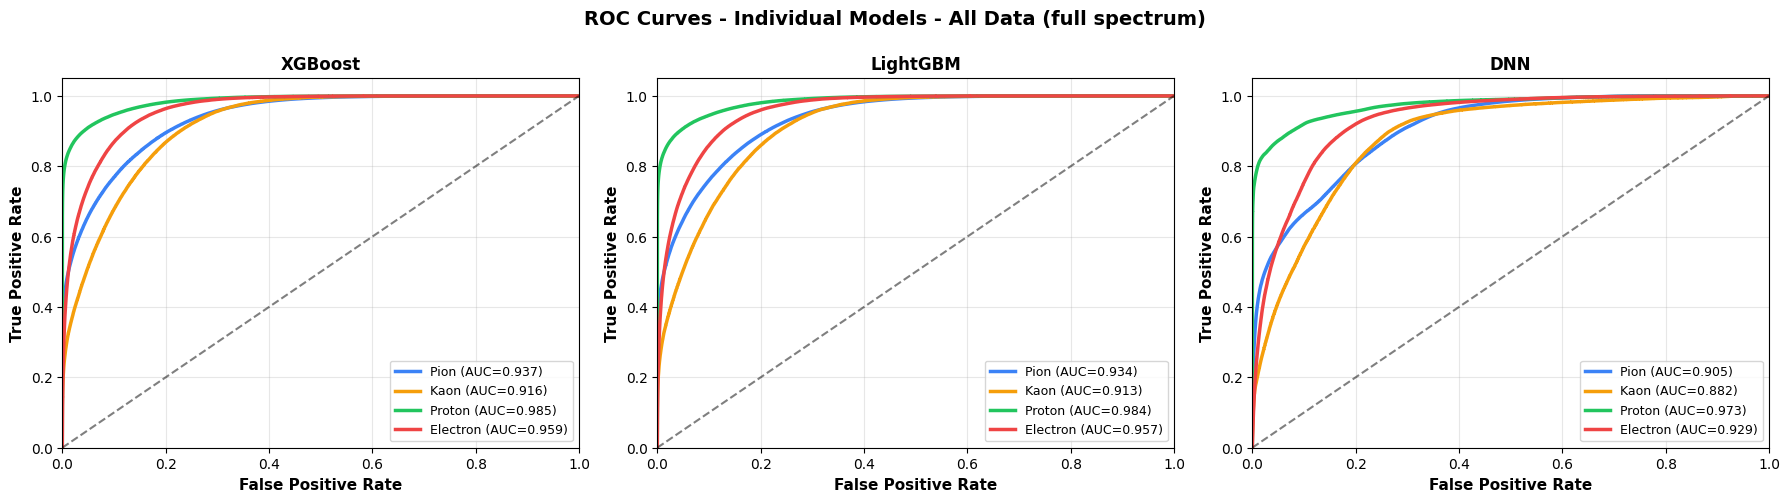

  ✓ Individual models ROC curves created

  Generating confusion matrices...


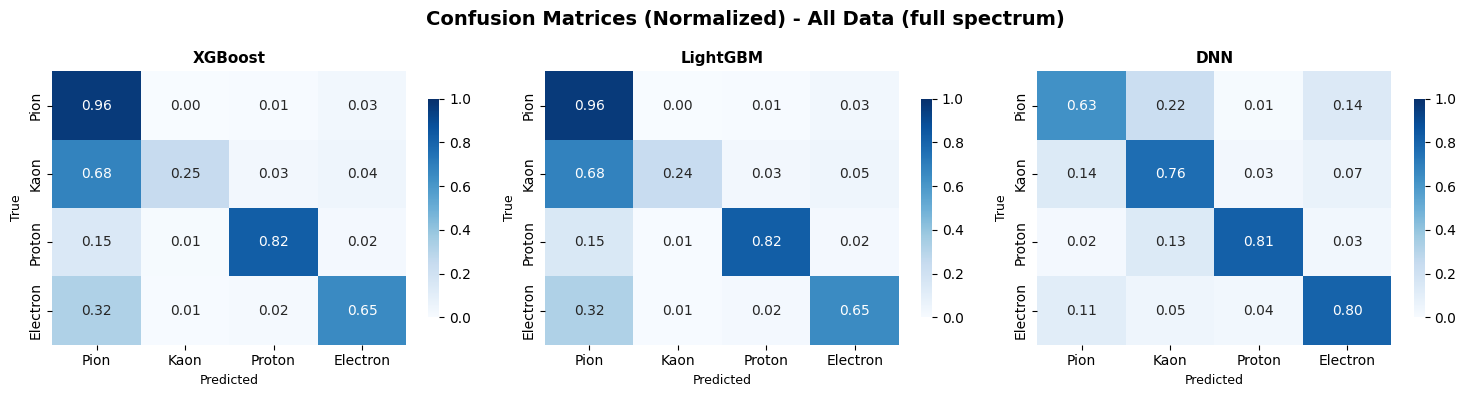

  ✓ Confusion matrices created

  Generating feature importance plots...


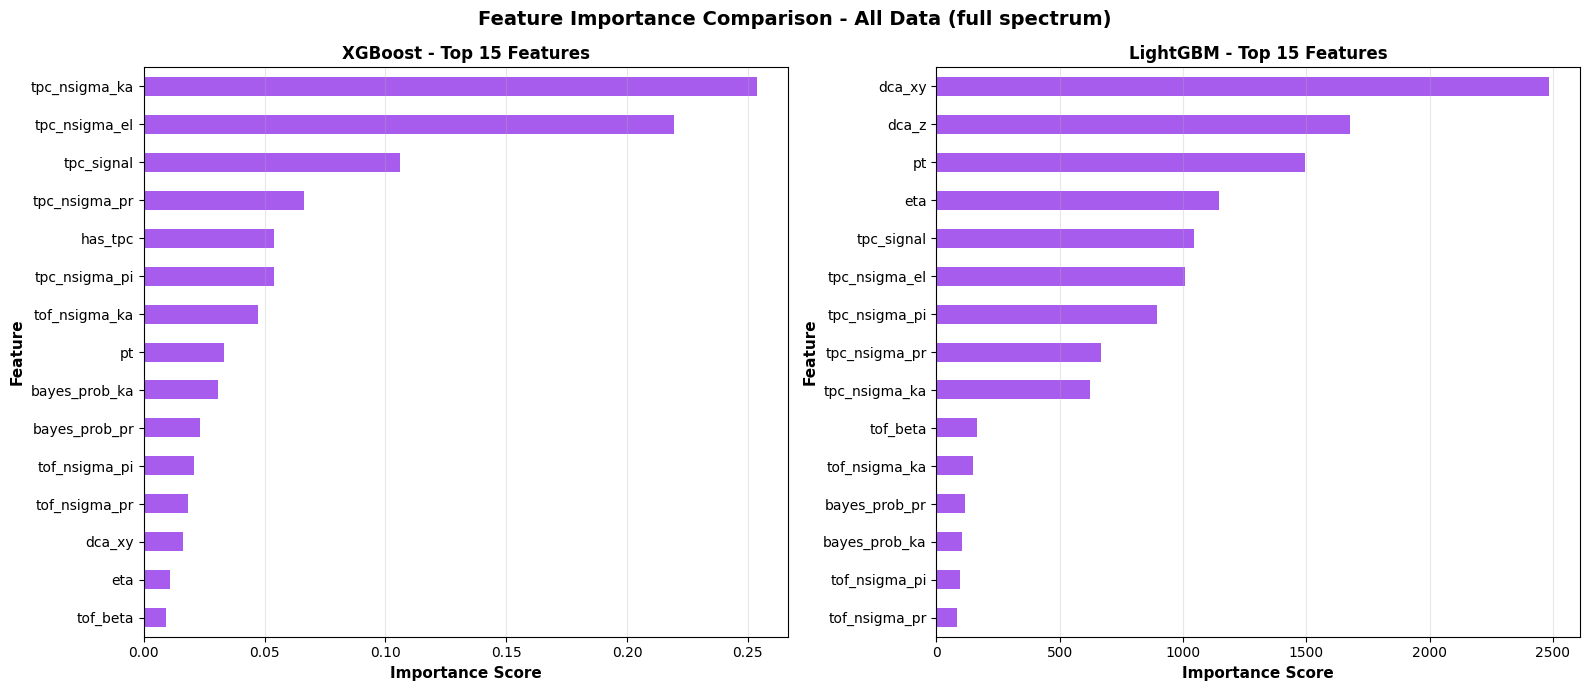

  ✓ Feature importance plots created

  Generating cumulative feature importance...


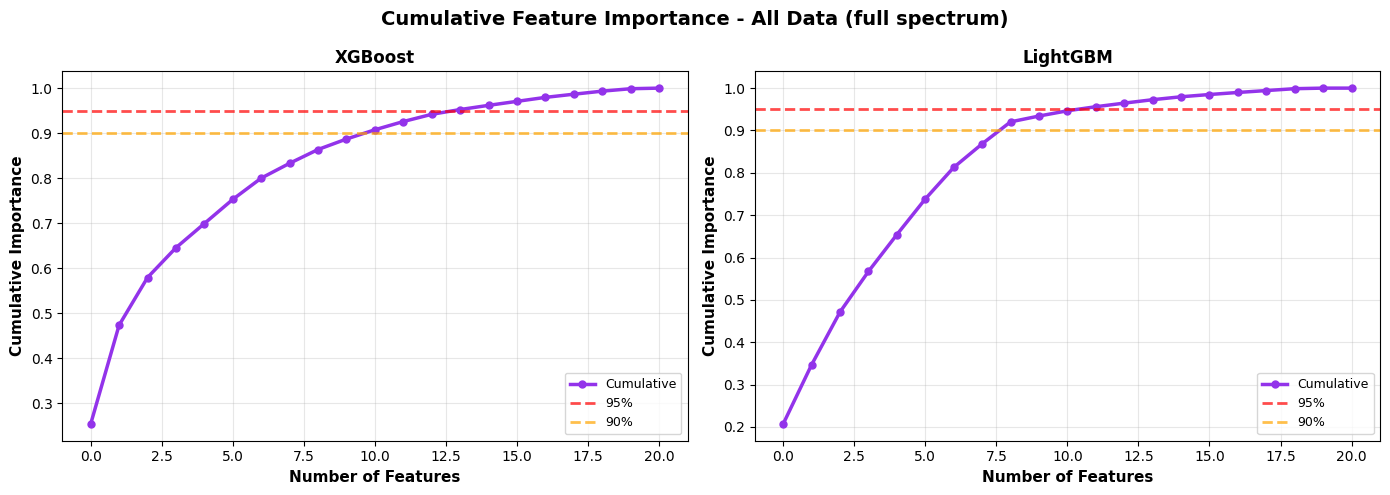

  ✓ Cumulative feature importance plots created


✓ ALL VISUALISATIONS COMPLETE


In [21]:
print("\n" + "="*80)
print("SECTION 9: MODEL VISUALISATIONS")
print("="*80)

particle_colours = ['#3B82F6', '#F59E0B', '#22C55E', '#EF4444', '#8B5CF6']

for range_key in ['full', '0.1-1', '1-3', '3+']:
    if range_key not in trained_xgb_models:
        continue

    range_name = momentum_datasets[range_key]['config']['name']
    print(f"\n{'='*70}")
    print(f"Visualisations: {range_name}")
    print(f"{'='*70}")

    y_test = momentum_datasets[range_key]['y_test'].values
    xgb_pred = trained_xgb_models[range_key]['model'].predict_proba(momentum_datasets[range_key]['X_test'].values.astype(np.float32))
    lgb_pred = trained_lgb_models[range_key]['model'].predict_proba(momentum_datasets[range_key]['X_test'].values.astype(np.float32))
    
    scaler = trained_dnn_models[range_key]['scaler']
    X_test_df = momentum_datasets[range_key]['X_test']
    X_test_scaled = scaler.transform(X_test_df)
    dnn_pred = trained_dnn_models[range_key]['model'].predict(X_test_scaled, verbose=0)

    # ============================================================================
    # 1. ROC CURVES - INDIVIDUAL MODELS (XGBoost, LightGBM, DNN)
    # ============================================================================
    print("\n  Generating ROC curves - Individual models...")
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for idx, (pred, title) in enumerate([
        (xgb_pred, 'XGBoost'),
        (lgb_pred, 'LightGBM'),
        (dnn_pred, 'DNN')
    ]):
        ax = axes[idx]
        for particle_idx in range(len(PARTICLE_NAMES)):
            colour = particle_colours[particle_idx] if particle_idx < len(particle_colours) else '#999999'

            y_bin = (y_test == particle_idx).astype(int)
            fpr, tpr, _ = roc_curve(y_bin, pred[:, particle_idx])
            roc_auc = auc(fpr, tpr)
            ax.plot(fpr, tpr, color=colour, lw=2.5, label=f"{PARTICLE_NAMES[particle_idx]} (AUC={roc_auc:.3f})")

        ax.plot([0, 1], [0, 1], 'k--', lw=1.5, alpha=0.5)
        ax.set_xlabel('False Positive Rate', fontsize=11, fontweight='bold')
        ax.set_ylabel('True Positive Rate', fontsize=11, fontweight='bold')
        ax.set_title(f'{title}', fontsize=12, fontweight='bold')
        ax.legend(fontsize=9, loc='lower right')
        ax.grid(alpha=0.3)
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])

    plt.suptitle(f'ROC Curves - Individual Models - {range_name}', fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    print("  ✓ Individual models ROC curves created")

    # ============================================================================
    # 2. CONFUSION MATRICES - INDIVIDUAL MODELS
    # ============================================================================
    print("\n  Generating confusion matrices...")
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    models_cm = [
        (xgb_pred, 'XGBoost'),
        (lgb_pred, 'LightGBM'),
        (dnn_pred, 'DNN'),
    ]

    for idx, (pred, title) in enumerate(models_cm):
        ax = axes[idx]
        y_pred_labels = np.argmax(pred, axis=1)
        cm = confusion_matrix(y_test, y_pred_labels, normalize='true')
        sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', ax=ax,
                    xticklabels=PARTICLE_NAMES, yticklabels=PARTICLE_NAMES,
                    cbar_kws={'shrink': 0.8}, vmin=0, vmax=1)
        ax.set_title(f'{title}', fontsize=11, fontweight='bold')
        ax.set_xlabel('Predicted', fontsize=9)
        ax.set_ylabel('True', fontsize=9)

    plt.suptitle(f'Confusion Matrices (Normalized) - {range_name}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    print("  ✓ Confusion matrices created")

    # ============================================================================
    # 3. FEATURE IMPORTANCE - XGBOOST & LIGHTGBM
    # ============================================================================
    print("\n  Generating feature importance plots...")
    try:
        fig, axes = plt.subplots(1, 2, figsize=(16, 7))

        fi_xgb = pd.Series(
            trained_xgb_models[range_key]['model'].feature_importances_,
            index=available_features
        ).sort_values(ascending=False)
        fi_xgb.head(15).plot(kind='barh', ax=axes[0],
                             color=momentum_datasets[range_key]['config']['color'], alpha=0.8)
        axes[0].set_xlabel('Importance Score', fontsize=11, fontweight='bold')
        axes[0].set_ylabel('Feature', fontsize=11, fontweight='bold')
        axes[0].set_title(f'XGBoost - Top 15 Features', fontsize=12, fontweight='bold')
        axes[0].invert_yaxis()
        axes[0].grid(axis='x', alpha=0.3)

        fi_lgb = pd.Series(
            trained_lgb_models[range_key]['model'].feature_importances_,
            index=available_features
        ).sort_values(ascending=False)
        fi_lgb.head(15).plot(kind='barh', ax=axes[1],
                             color=momentum_datasets[range_key]['config']['color'], alpha=0.8)
        axes[1].set_xlabel('Importance Score', fontsize=11, fontweight='bold')
        axes[1].set_ylabel('Feature', fontsize=11, fontweight='bold')
        axes[1].set_title(f'LightGBM - Top 15 Features', fontsize=12, fontweight='bold')
        axes[1].invert_yaxis()
        axes[1].grid(axis='x', alpha=0.3)

        plt.suptitle(f'Feature Importance Comparison - {range_name}', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        print("  ✓ Feature importance plots created")
    except Exception as e:
        print(f"  ⚠ Could not create feature importance plots: {str(e)[:50]}")

    # ============================================================================
    # 4. CUMULATIVE FEATURE IMPORTANCE
    # ============================================================================
    print("\n  Generating cumulative feature importance...")
    try:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        fi_xgb = pd.Series(trained_xgb_models[range_key]['model'].feature_importances_,
                           index=available_features).sort_values(ascending=False)
        cumsum_xgb = fi_xgb.values.cumsum() / fi_xgb.values.sum()

        axes[0].plot(range(len(cumsum_xgb)), cumsum_xgb, 'o-', linewidth=2.5, markersize=5,
                     color=momentum_datasets[range_key]['config']['color'], label='Cumulative')
        axes[0].axhline(y=0.95, color='r', linestyle='--', alpha=0.7, linewidth=2, label='95%')
        axes[0].axhline(y=0.90, color='orange', linestyle='--', alpha=0.7, linewidth=2, label='90%')
        axes[0].set_xlabel('Number of Features', fontsize=11, fontweight='bold')
        axes[0].set_ylabel('Cumulative Importance', fontsize=11, fontweight='bold')
        axes[0].set_title(f'XGBoost', fontsize=12, fontweight='bold')
        axes[0].legend(fontsize=9)
        axes[0].grid(alpha=0.3)

        fi_lgb = pd.Series(trained_lgb_models[range_key]['model'].feature_importances_,
                           index=available_features).sort_values(ascending=False)
        cumsum_lgb = fi_lgb.values.cumsum() / fi_lgb.values.sum()

        axes[1].plot(range(len(cumsum_lgb)), cumsum_lgb, 'o-', linewidth=2.5, markersize=5,
                     color=momentum_datasets[range_key]['config']['color'], label='Cumulative')
        axes[1].axhline(y=0.95, color='r', linestyle='--', alpha=0.7, linewidth=2, label='95%')
        axes[1].axhline(y=0.90, color='orange', linestyle='--', alpha=0.7, linewidth=2, label='90%')
        axes[1].set_xlabel('Number of Features', fontsize=11, fontweight='bold')
        axes[1].set_ylabel('Cumulative Importance', fontsize=11, fontweight='bold')
        axes[1].set_title(f'LightGBM', fontsize=12, fontweight='bold')
        axes[1].legend(fontsize=9)
        axes[1].grid(alpha=0.3)

        plt.suptitle(f'Cumulative Feature Importance - {range_name}', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        print("  ✓ Cumulative feature importance plots created")
    except Exception as e:
        print(f"  ⚠ Could not create cumulative feature importance plots: {str(e)[:50]}")

    print("\n")

print("="*80)
print("✓ ALL VISUALISATIONS COMPLETE")
print("="*80)

## SECTION 10: Visualisations II
### Compare Models Across Momentum Ranges


SECTION 10: STATIC VISUALISATIONS (INDIVIDUAL MODELS ONLY)

PART 1: BAR CHARTS - Efficiency & Purity Across Momentum Ranges

Generating efficiency plots for model: XGBoost


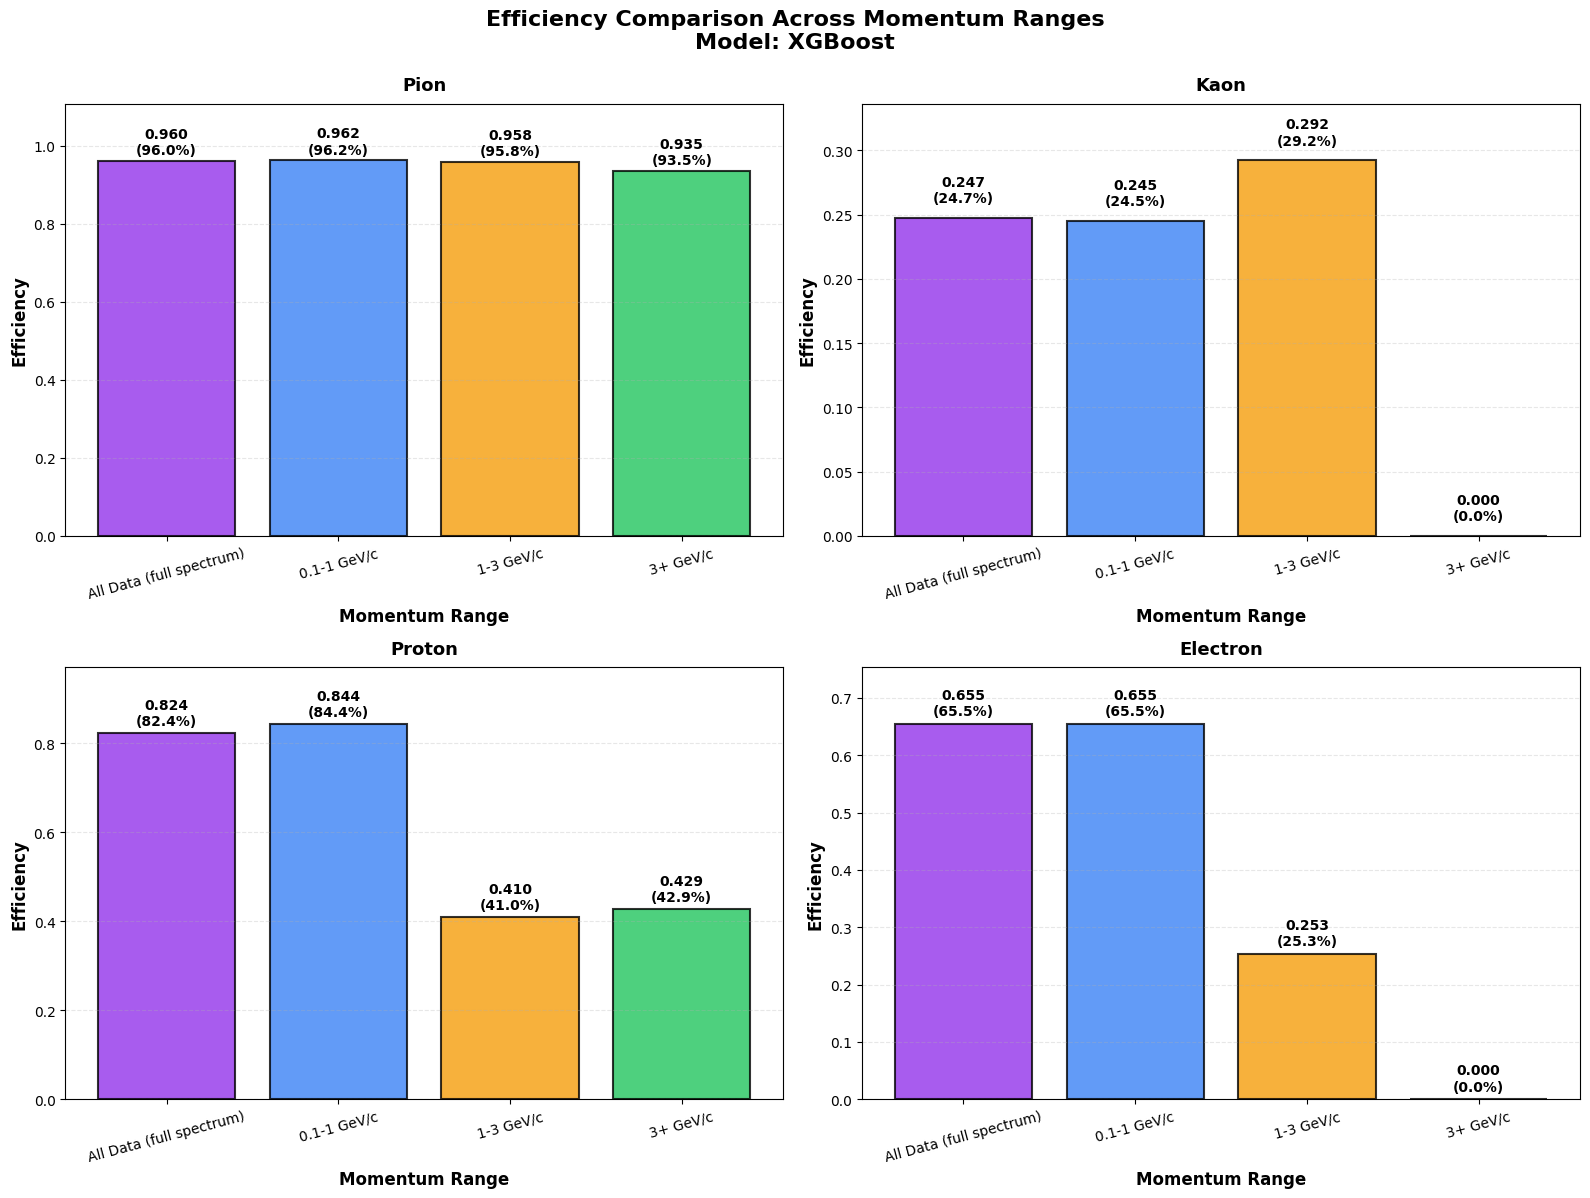


Generating purity plots for model: XGBoost


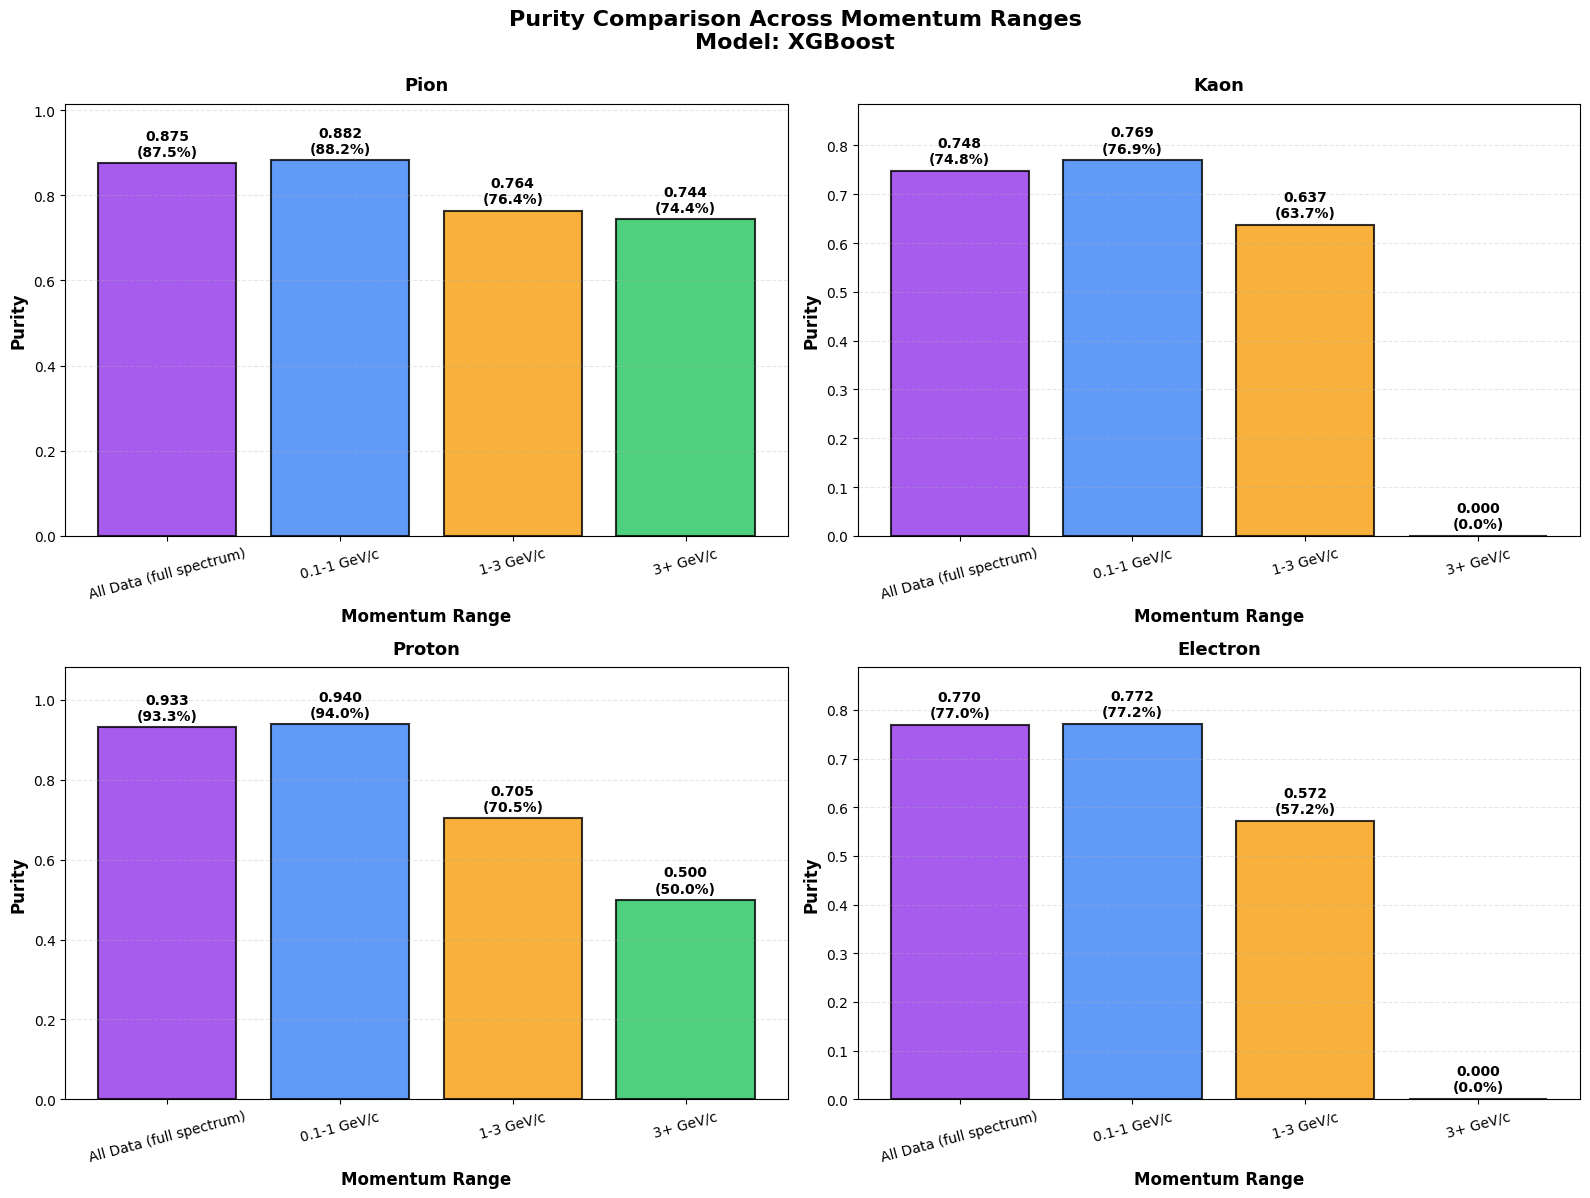


Generating efficiency plots for model: LightGBM


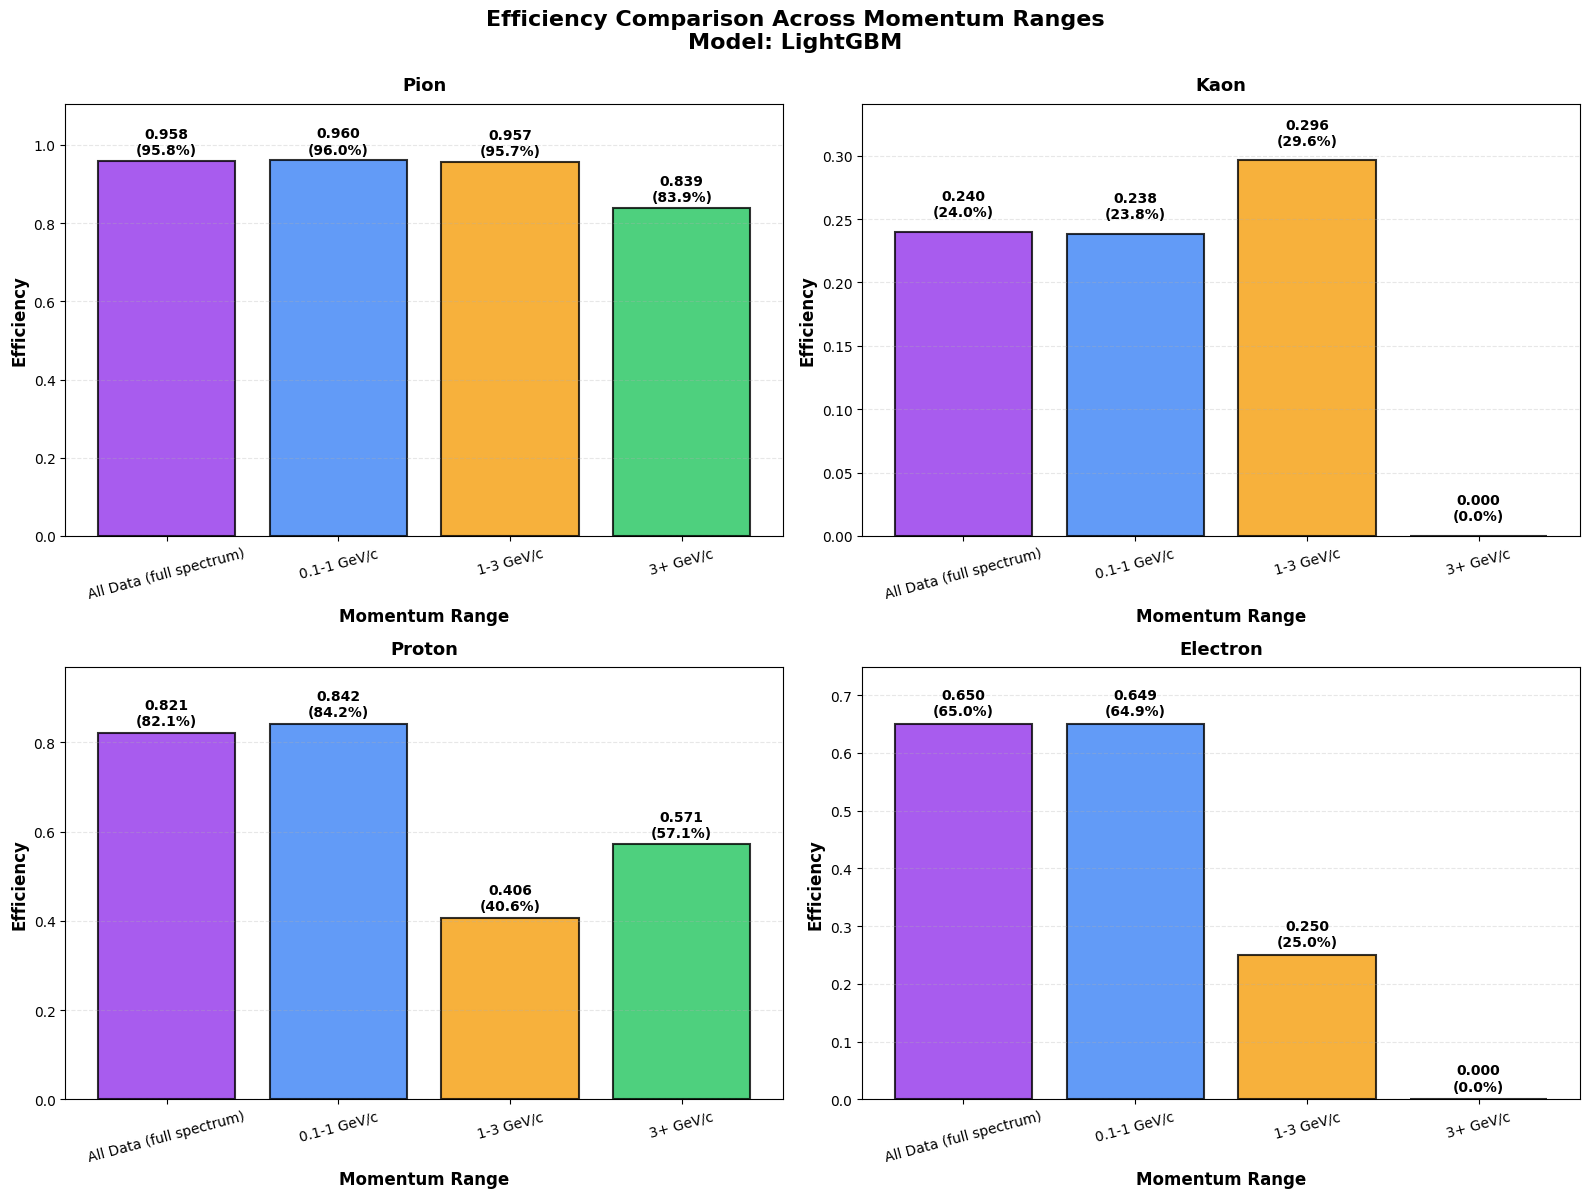


Generating purity plots for model: LightGBM


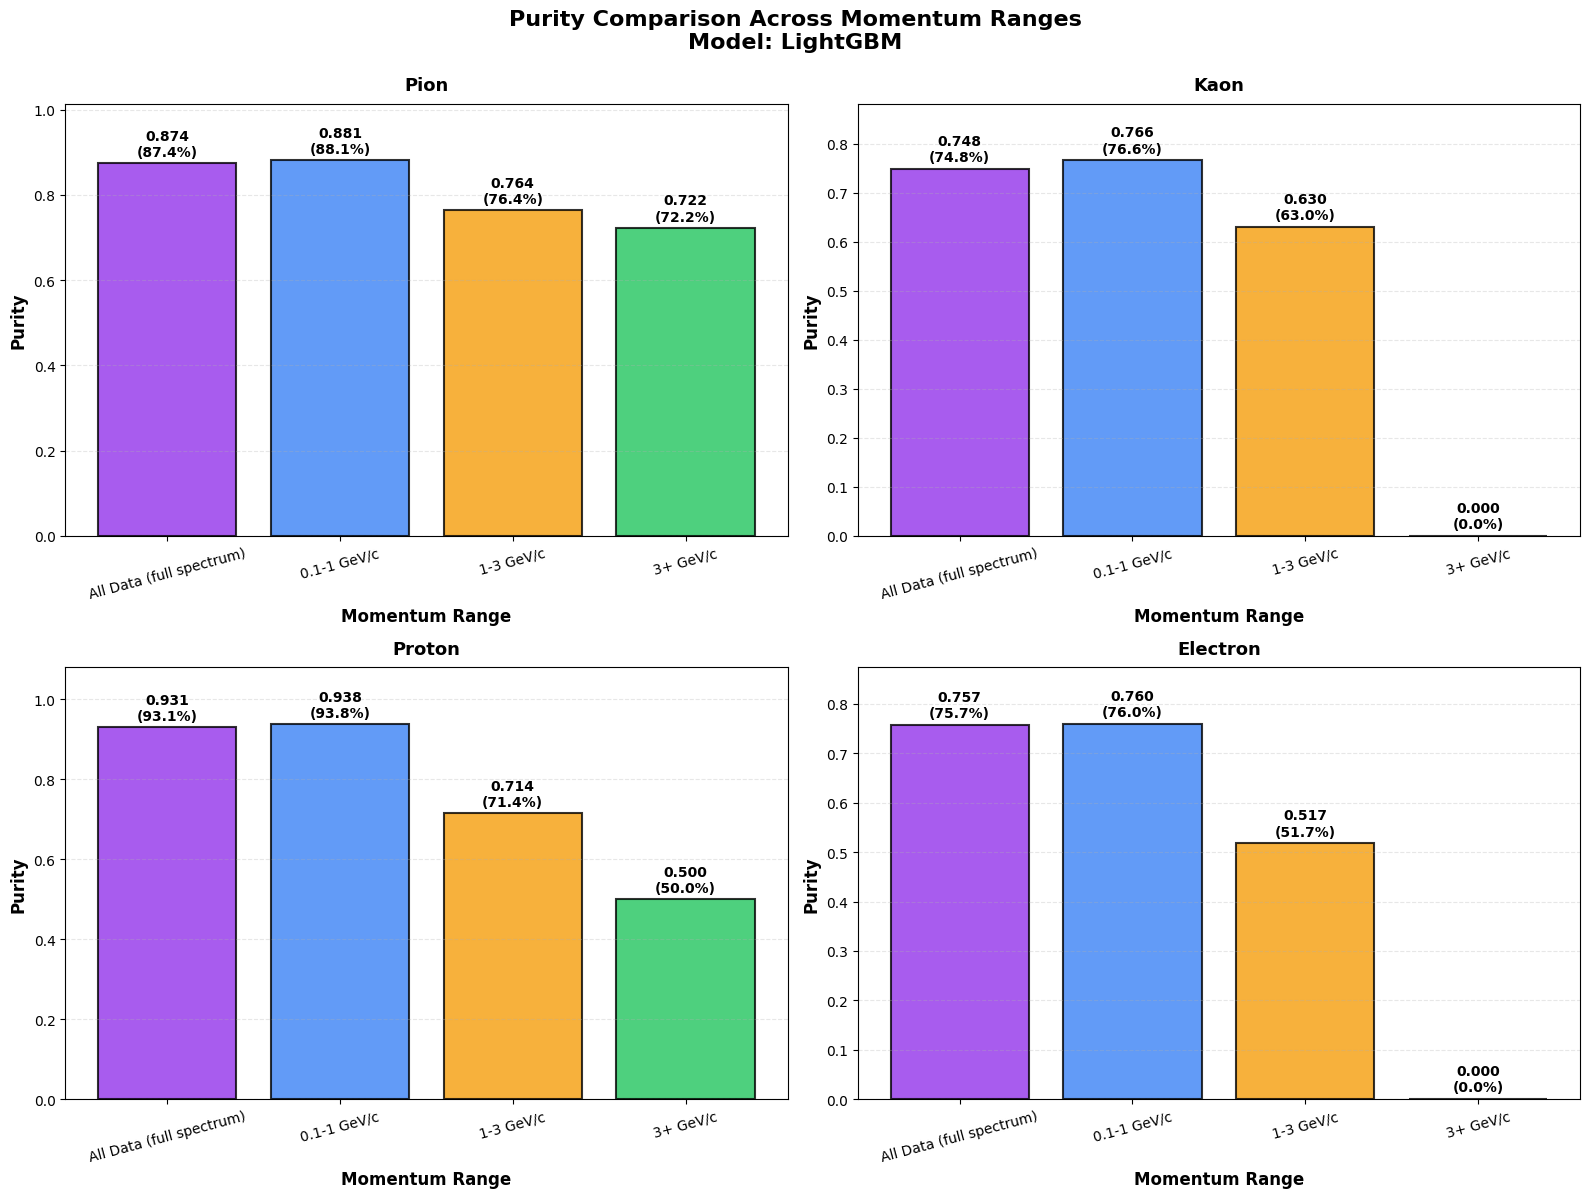


Generating efficiency plots for model: DNN


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but StandardScaler was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but StandardScaler was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but StandardScaler was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but StandardScaler was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but StandardScaler was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but StandardScaler was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but Standa

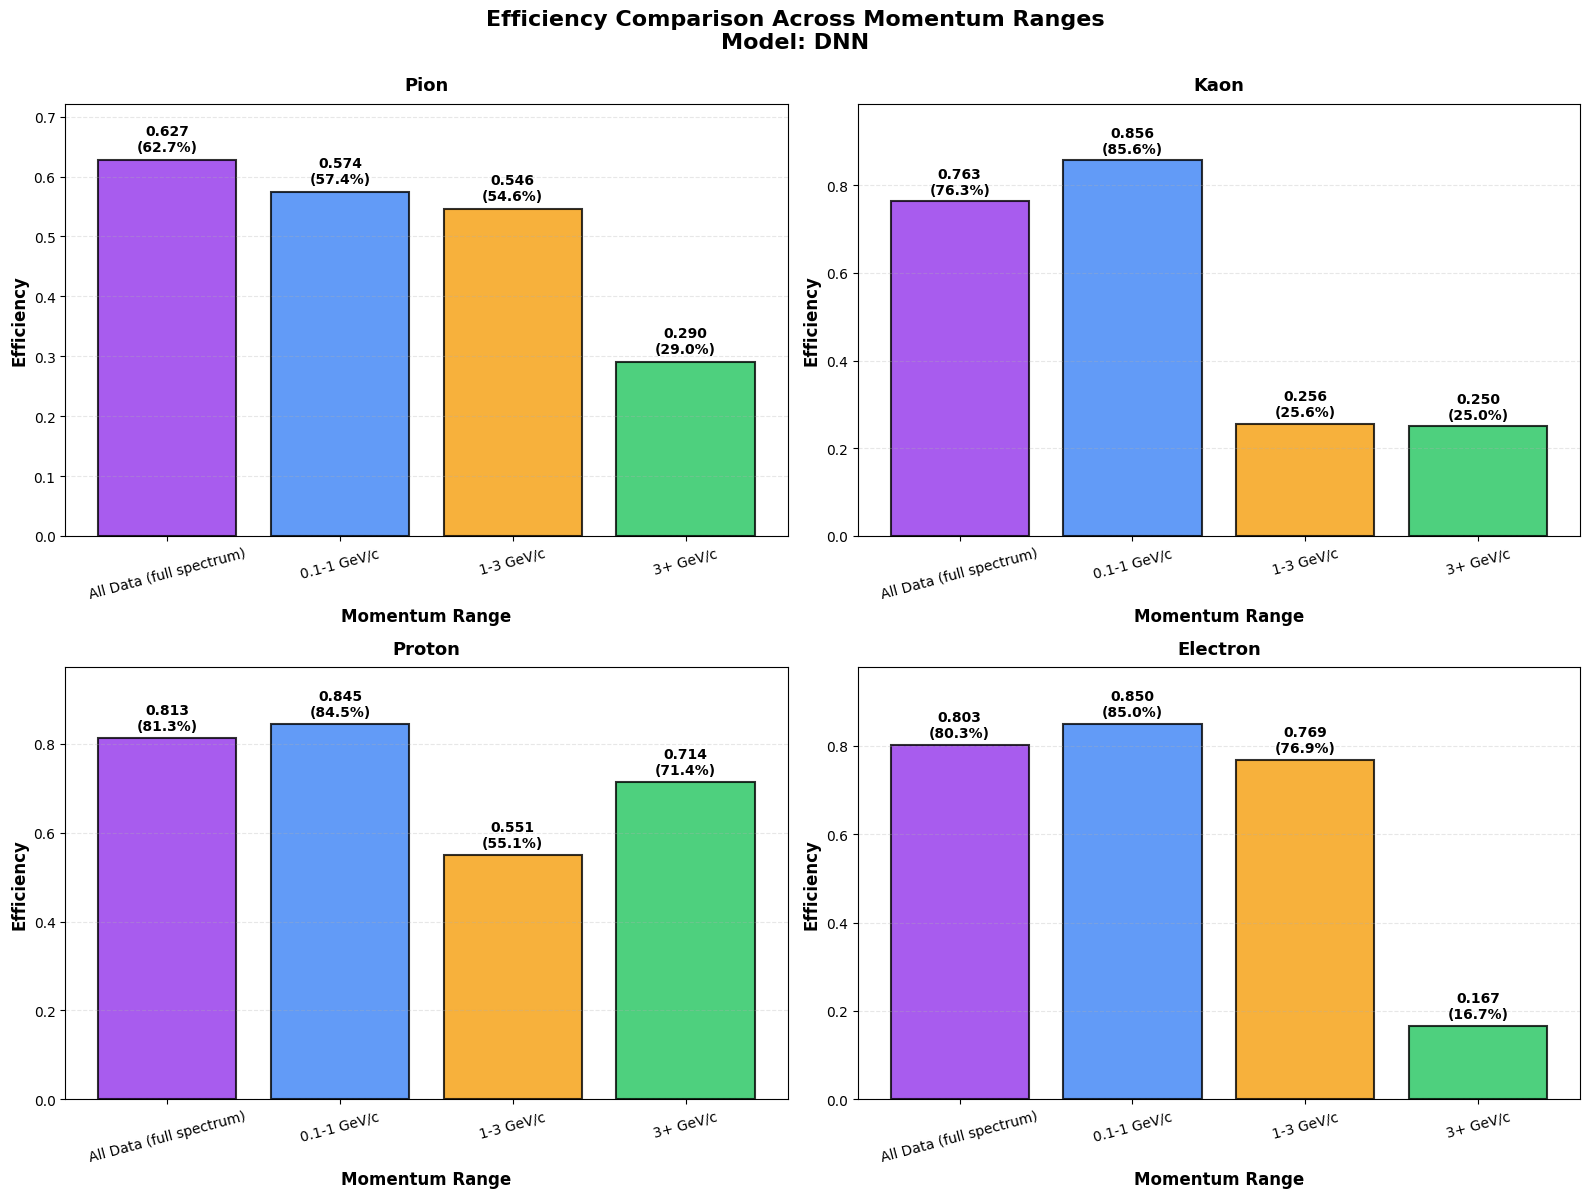


Generating purity plots for model: DNN


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but StandardScaler was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but StandardScaler was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but StandardScaler was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but StandardScaler was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but StandardScaler was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but StandardScaler was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but Standa

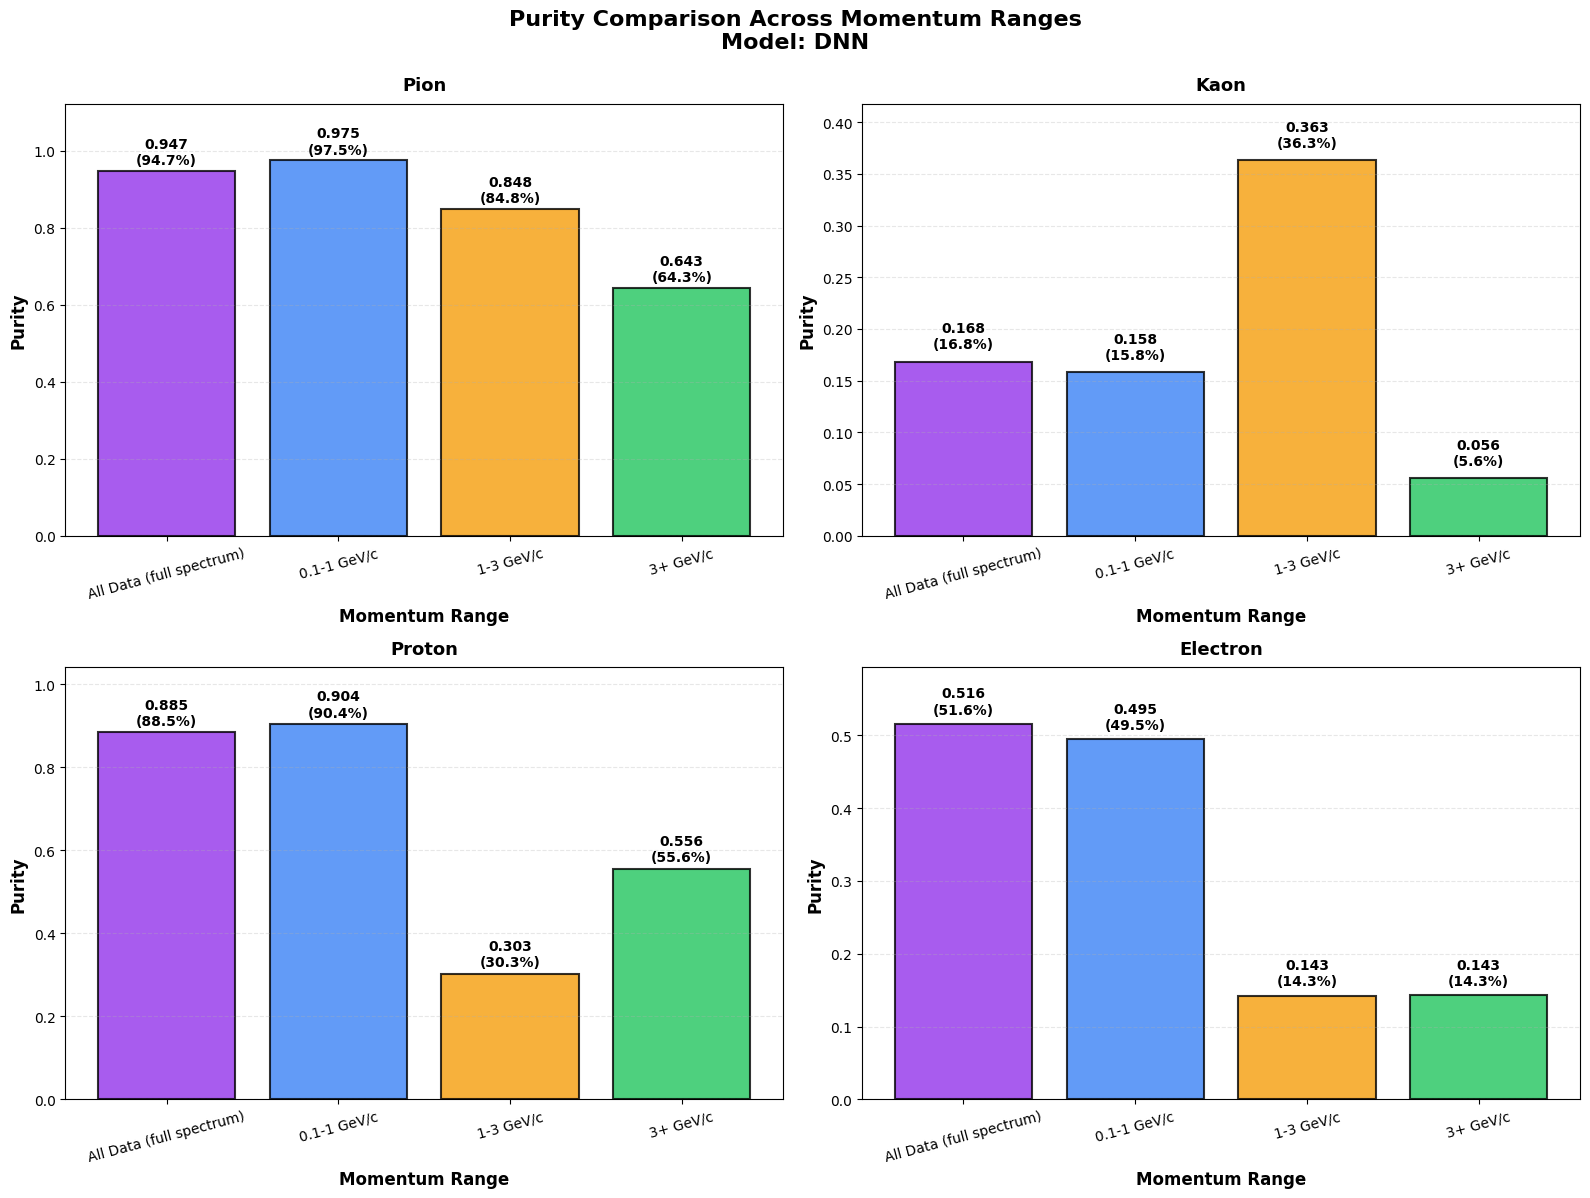


PART 2: DETAILED METRICS TABLES

MODEL: XGBOOST

PION
----------------------------------------------------------------------------------------------------
          Momentum Range Efficiency Purity     TP     FP
All Data (full spectrum)     0.9599 0.8755 829260 117961
             0.1-1 GeV/c     0.9623 0.8817 795206 106680
               1-3 GeV/c     0.9585 0.7640  24130   7453
                3+ GeV/c     0.9355 0.7436     29     10

KAON
----------------------------------------------------------------------------------------------------
          Momentum Range Efficiency Purity    TP   FP
All Data (full spectrum)     0.2474 0.7476 14668 4952
             0.1-1 GeV/c     0.2451 0.7692 13020 3906
               1-3 GeV/c     0.2922 0.6366  1659  947
                3+ GeV/c     0.0000 0.0000     0    2

PROTON
----------------------------------------------------------------------------------------------------
          Momentum Range Efficiency Purity     TP   FP
All Data (full spe

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but StandardScaler was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but StandardScaler was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but StandardScaler was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but StandardScaler was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but StandardScaler was fitted without feature names




PION
----------------------------------------------------------------------------------------------------
          Momentum Range Efficiency Purity     TP    FP
All Data (full spectrum)     0.6270 0.9467 541657 30491
             0.1-1 GeV/c     0.5744 0.9748 474698 12280
               1-3 GeV/c     0.5457 0.8481  13738  2461
                3+ GeV/c     0.2903 0.6429      9     5


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but StandardScaler was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but StandardScaler was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but StandardScaler was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but StandardScaler was fitted without feature names




KAON
----------------------------------------------------------------------------------------------------
          Momentum Range Efficiency Purity    TP     FP
All Data (full spectrum)     0.7634 0.1684 45257 223437
             0.1-1 GeV/c     0.8563 0.1582 45491 242094
               1-3 GeV/c     0.2561 0.3630  1454   2552
                3+ GeV/c     0.2500 0.0556     1     17


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but StandardScaler was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but StandardScaler was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but StandardScaler was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but StandardScaler was fitted without feature names




PROTON
----------------------------------------------------------------------------------------------------
          Momentum Range Efficiency Purity     TP    FP
All Data (full spectrum)     0.8134 0.8847 126350 16472
             0.1-1 GeV/c     0.8448 0.9041 125068 13260
               1-3 GeV/c     0.5508 0.3026   3477  8014
                3+ GeV/c     0.7143 0.5556      5     4


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but StandardScaler was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but StandardScaler was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but StandardScaler was fitted without feature names




ELECTRON
----------------------------------------------------------------------------------------------------
          Momentum Range Efficiency Purity     TP     FP
All Data (full spectrum)     0.8027 0.5160 137012 128511
             0.1-1 GeV/c     0.8502 0.4946 135624 138561
               1-3 GeV/c     0.7687 0.1425    957   5758
                3+ GeV/c     0.1667 0.1429      1      6

PART 3: ROC CURVES - All Particles Across Momentum Ranges

Generating ROC curves for model: XGBoost


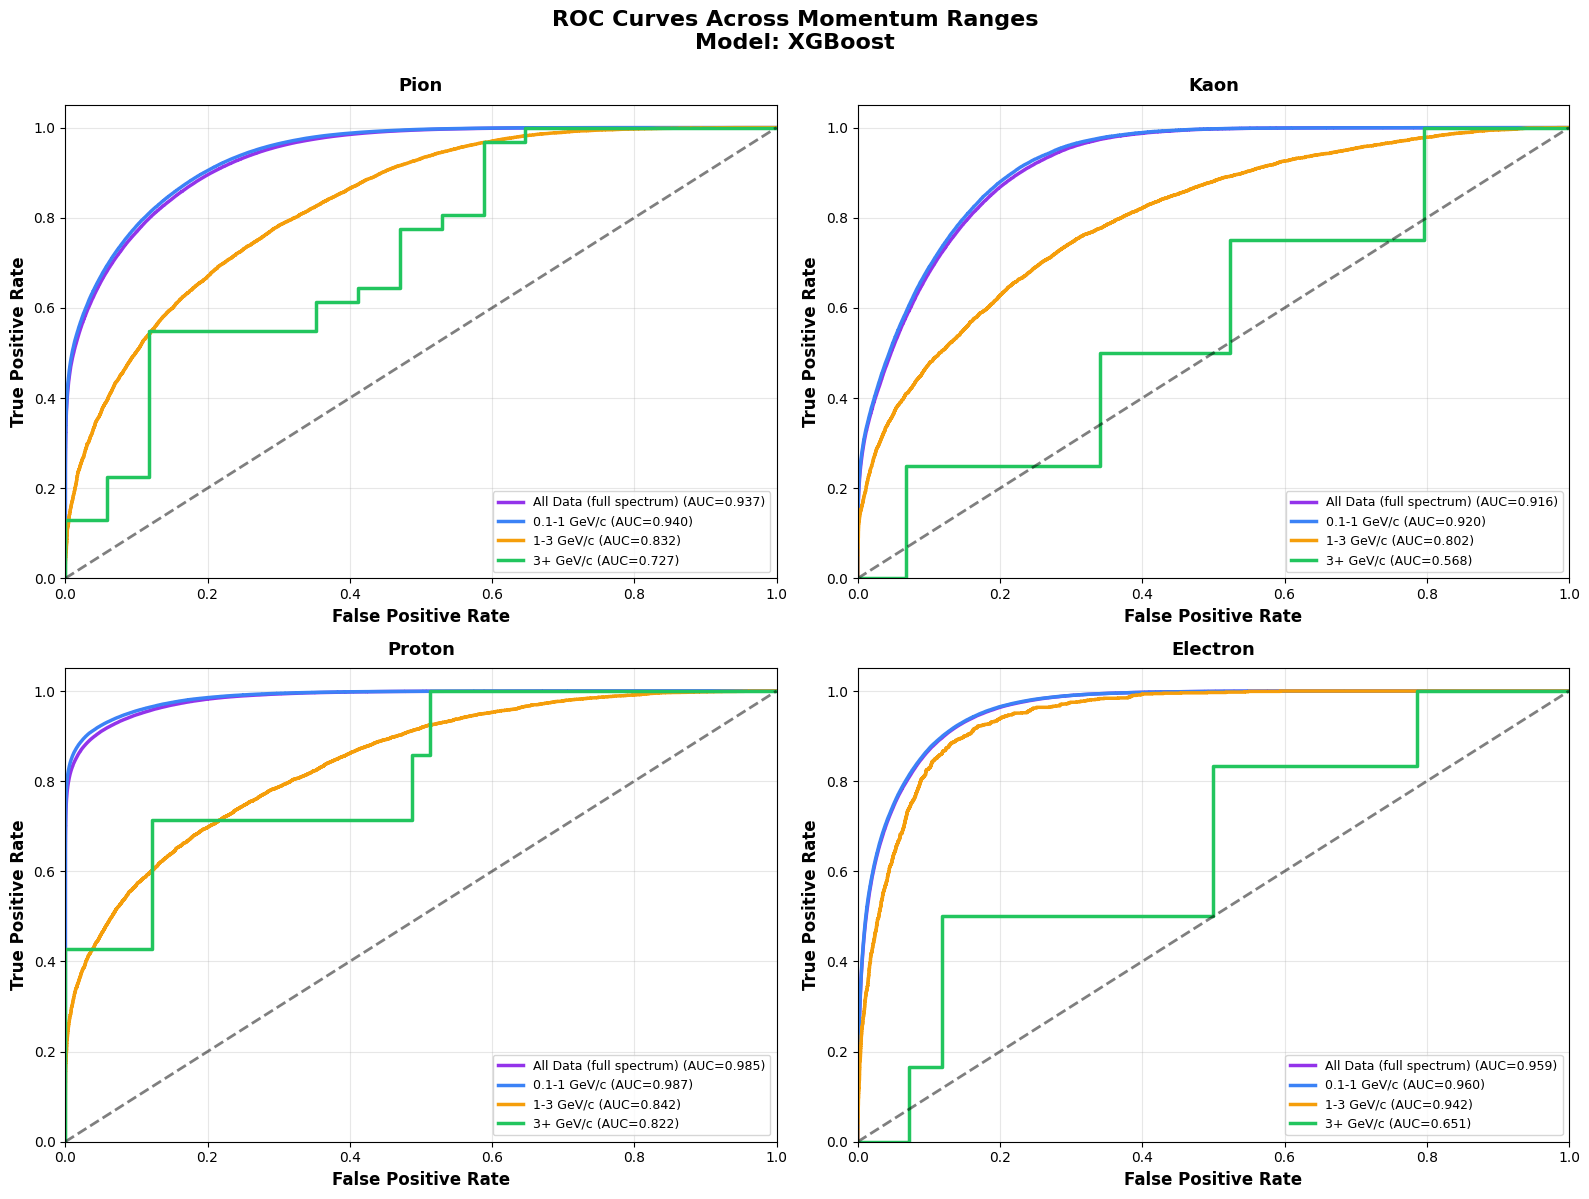


Generating ROC curves for model: LightGBM


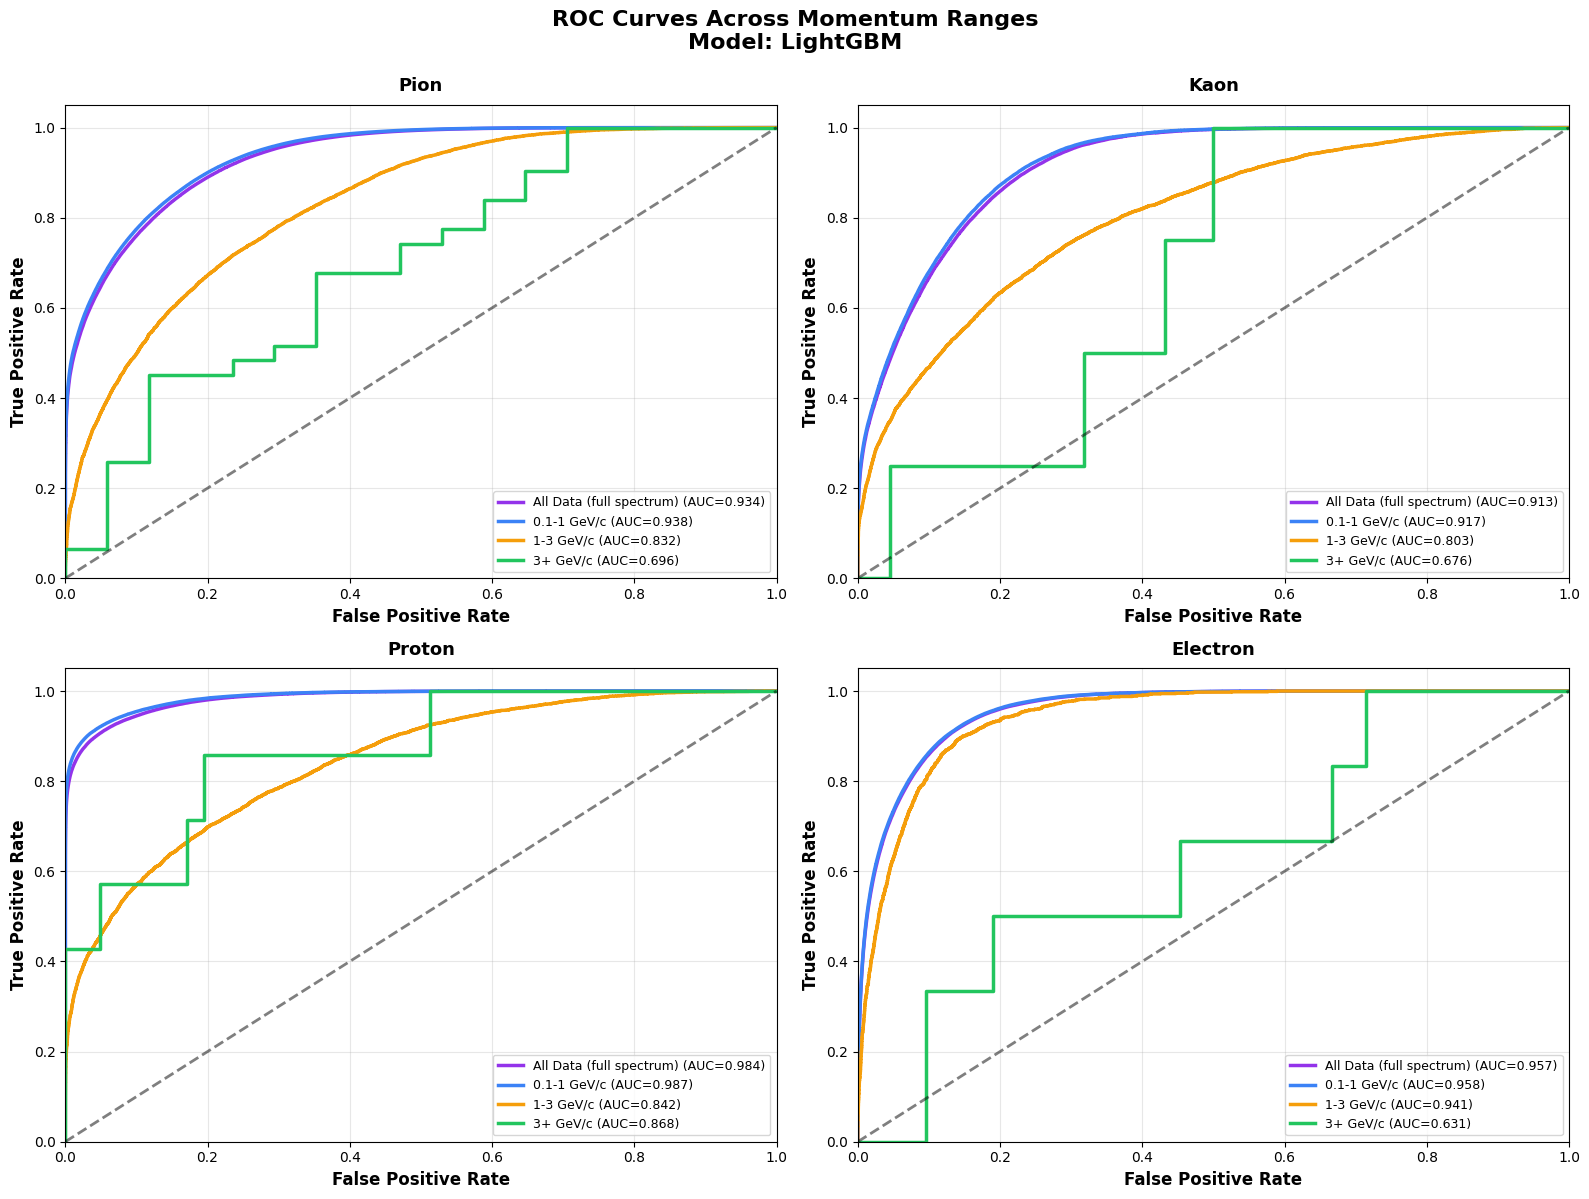


Generating ROC curves for model: DNN


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but StandardScaler was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but StandardScaler was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but StandardScaler was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but StandardScaler was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but StandardScaler was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but StandardScaler was fitted without feature names

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but Standa

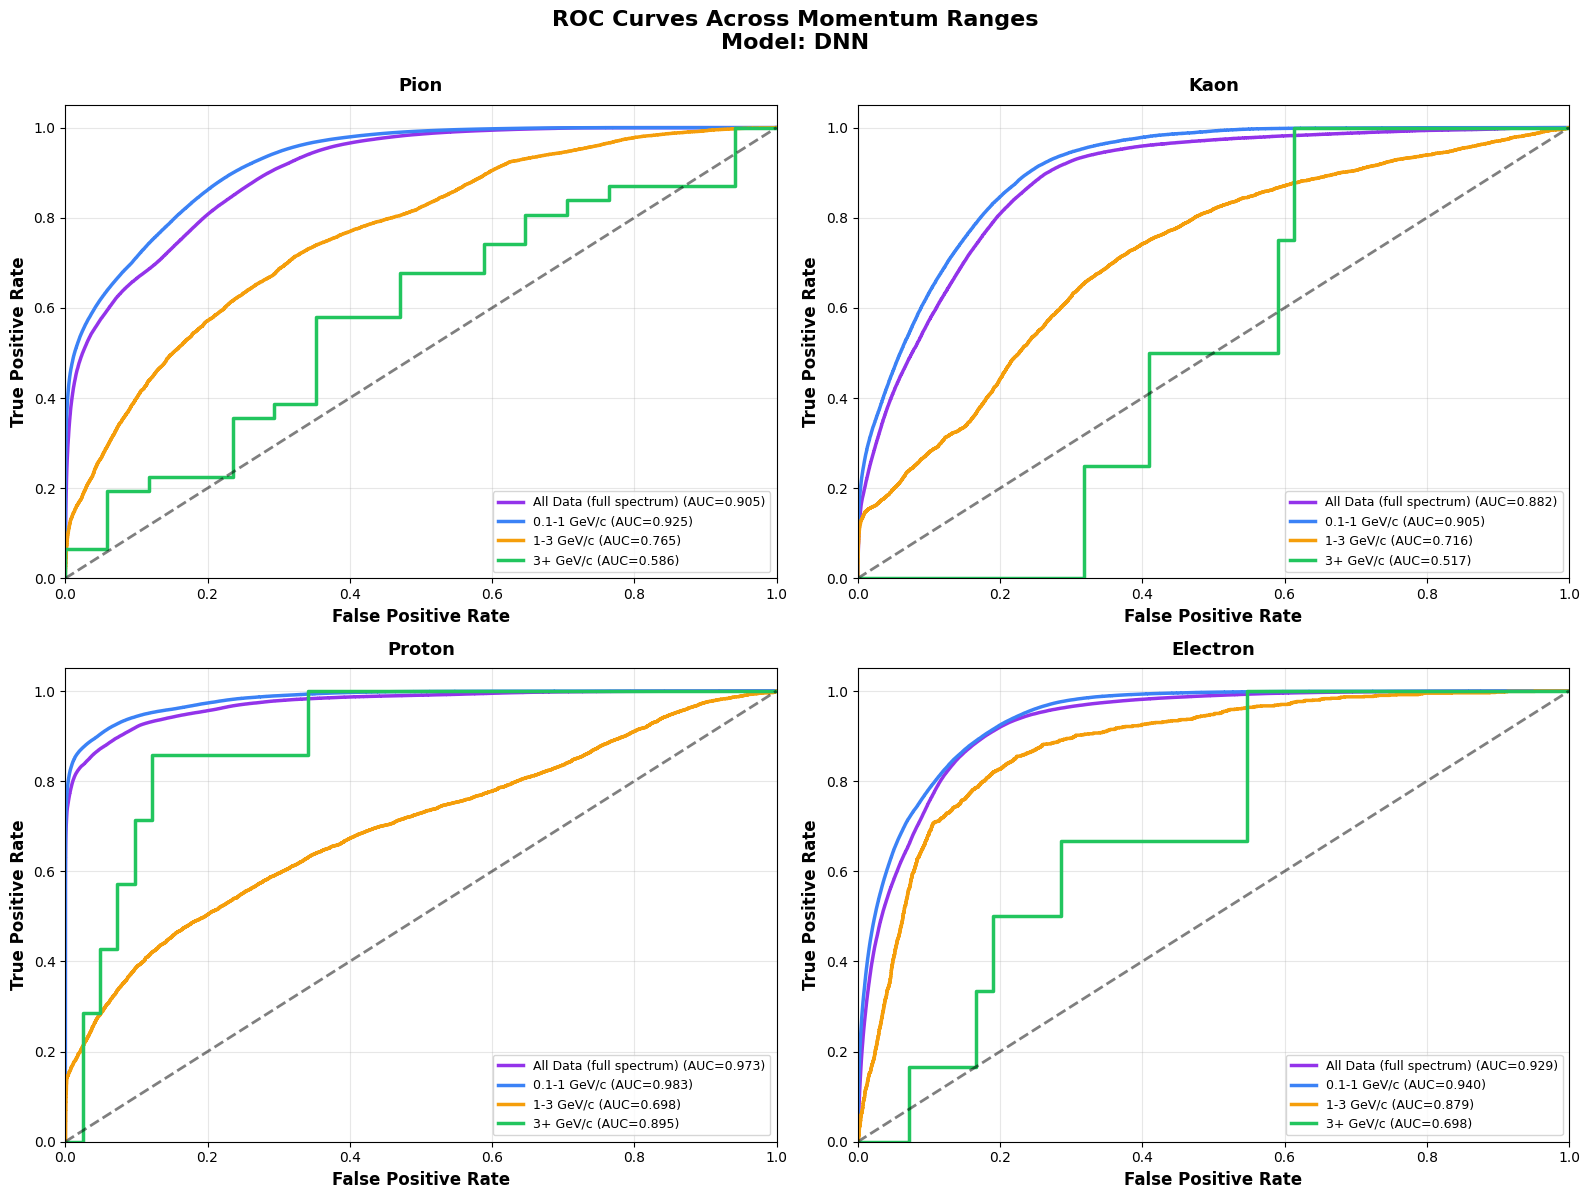


✓ All individual model visualisations complete


In [22]:
print("\n" + "="*80)
print("SECTION 10: STATIC VISUALISATIONS (INDIVIDUAL MODELS ONLY)")
print("="*80)

# HELPER FUNCTIONS FOR STATIC PLOTS
def compute_pid_metrics(range_key, model_key):
    if range_key not in momentum_datasets:
        return None

    y_test = momentum_datasets[range_key]['y_test'].values

    if model_key == 'XGBoost':
        y_pred_proba = trained_xgb_models[range_key]['model'].predict_proba(momentum_datasets[range_key]['X_test'].values.astype(np.float32))
    elif model_key == 'LightGBM':
        y_pred_proba = trained_lgb_models[range_key]['model'].predict_proba(momentum_datasets[range_key]['X_test'].values.astype(np.float32))
    elif model_key == 'DNN':
        scaler = trained_dnn_models[range_key]['scaler']
        X_test_df = momentum_datasets[range_key]['X_test']  # preserve feature names
        X_test_scaled = scaler.transform(X_test_df)
        y_pred_proba = trained_dnn_models[range_key]['model'].predict(X_test_scaled, verbose=0)
    else:
        return None

    y_pred_labels = np.argmax(y_pred_proba, axis=1)

    metrics_dict = {}
    for particle_idx, particle_name in enumerate(PARTICLE_NAMES):
        y_bin = (y_test == particle_idx).astype(int)
        y_pred_bin = (y_pred_labels == particle_idx).astype(int)

        tp = np.sum((y_bin == 1) & (y_pred_bin == 1))
        fp = np.sum((y_bin == 0) & (y_pred_bin == 1))
        fn = np.sum((y_bin == 1) & (y_pred_bin == 0))
        tn = np.sum((y_bin == 0) & (y_pred_bin == 0))

        efficiency = tp / (tp + fn) if (tp + fn) > 0 else 0
        purity = tp / (tp + fp) if (tp + fp) > 0 else 0

        metrics_dict[particle_name] = {
            'efficiency': efficiency,
            'purity': purity,
            'tp': int(tp),
            'fp': int(fp)
        }

    return metrics_dict


print("\n" + "="*80)
print("PART 1: BAR CHARTS - Efficiency & Purity Across Momentum Ranges")
print("="*80)

models = ['XGBoost', 'LightGBM', 'DNN']
metrics = ['efficiency', 'purity']

for model_key in models:
    for metric in metrics:
        print(f"\nGenerating {metric} plots for model: {model_key}")

        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle(f'{metric.capitalize()} Comparison Across Momentum Ranges\nModel: {model_key}',
                     fontsize=16, fontweight='bold', y=0.995)

        for idx, particle in enumerate(PARTICLE_NAMES):
            ax = axes[idx // 2, idx % 2]

            ranges = list(momentum_datasets.keys())
            values = []
            colors_list = []
            labels = []

            for r in ranges:
                metrics_data = compute_pid_metrics(r, model_key)
                if metrics_data and particle in metrics_data:
                    values.append(metrics_data[particle][metric])
                    colors_list.append(momentum_datasets[r]['config']['color'])
                    labels.append(momentum_datasets[r]['config']['name'])

            if values:
                bars = ax.bar(labels, values, color=colors_list, alpha=0.8, edgecolor='black', linewidth=1.5)

                for bar, val in zip(bars, values):
                    ax.text(bar.get_x() + bar.get_width() / 2., bar.get_height() + 0.01,
                            f'{val:.3f}\n({val * 100:.1f}%)',
                            ha='center', va='bottom', fontsize=10, fontweight='bold')

                ax.set_ylabel(metric.capitalize(), fontsize=12, fontweight='bold')
                ax.set_xlabel('Momentum Range', fontsize=12, fontweight='bold')
                ax.set_title(f'{particle}', fontsize=13, fontweight='bold', pad=10)
                ax.tick_params(axis='x', rotation=15)
                ax.grid(axis='y', alpha=0.3, linestyle='--')

                y_max = max(values)
                if y_max == 0:
                    y_max = 1
                ax.set_ylim(0, y_max * 1.15)

        plt.tight_layout()
        plt.show()

print("\n" + "="*80)
print("PART 2: DETAILED METRICS TABLES")
print("="*80)

for model_key in models:
    print(f"\n{'=' * 100}")
    print(f"MODEL: {model_key.upper()}")
    print(f"{'=' * 100}")

    for particle in PARTICLE_NAMES:
        ranges = list(momentum_datasets.keys())
        data = []

        for r in ranges:
            metrics_data = compute_pid_metrics(r, model_key)
            if metrics_data and particle in metrics_data:
                m = metrics_data[particle]
                data.append({
                    'Momentum Range': momentum_datasets[r]['config']['name'],
                    'Efficiency': f"{m['efficiency']:.4f}",
                    'Purity': f"{m['purity']:.4f}",
                    'TP': m['tp'],
                    'FP': m['fp']
                })

        if data:
            df_t = pd.DataFrame(data)
            print(f"\n{particle.upper()}")
            print("-" * 100)
            print(df_t.to_string(index=False))

print("\n" + "=" * 80)
print("PART 3: ROC CURVES - All Particles Across Momentum Ranges")
print("=" * 80)

for model_key in models:
    print(f"\nGenerating ROC curves for model: {model_key}")

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'ROC Curves Across Momentum Ranges\nModel: {model_key}',
                 fontsize=16, fontweight='bold', y=0.995)

    for idx, particle in enumerate(PARTICLE_NAMES):
        ax = axes[idx // 2, idx % 2]
        particle_idx = PARTICLE_NAMES.index(particle)

        for range_key in momentum_datasets.keys():
            try:
                if model_key == 'XGBoost':
                    if range_key not in trained_xgb_models:
                        continue
                    y_pred_proba = trained_xgb_models[range_key]['model'].predict_proba(
                        momentum_datasets[range_key]['X_test'].values.astype(np.float32))
                elif model_key == 'LightGBM':
                    if range_key not in trained_lgb_models:
                        continue
                    y_pred_proba = trained_lgb_models[range_key]['model'].predict_proba(
                        momentum_datasets[range_key]['X_test'].values.astype(np.float32))
                elif model_key == 'DNN':
                    if range_key not in trained_dnn_models:
                        continue
                    scaler = trained_dnn_models[range_key]['scaler']
                    X_test_df = momentum_datasets[range_key]['X_test']
                    X_test_scaled = scaler.transform(X_test_df)
                    y_pred_proba = trained_dnn_models[range_key]['model'].predict(X_test_scaled, verbose=0)
                else:
                    continue

                y_test = momentum_datasets[range_key]['y_test'].values
                y_bin = (y_test == particle_idx).astype(int)
                fpr, tpr, _ = roc_curve(y_bin, y_pred_proba[:, particle_idx])
                roc_auc = auc(fpr, tpr)

                ax.plot(fpr, tpr, color=momentum_datasets[range_key]['config']['color'], lw=2.5,
                        label=f"{momentum_datasets[range_key]['config']['name']} (AUC={roc_auc:.3f})")
            except Exception:
                # Optionally print debug info here if needed
                continue

        ax.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.5)
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
        ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
        ax.set_title(f'{particle}', fontsize=13, fontweight='bold', pad=10)
        ax.legend(loc='lower right', fontsize=9)
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

print("\n✓ All individual model visualisations complete")

## SECTION 11: Final Summary
### Analysis Complete - Results Overview

In [23]:
print("\n" + "="*80)
print("SECTION 11: ANALYSIS COMPLETE - FINAL SUMMARY")
print("="*80)

print(f"\nModels trained for {len(momentum_datasets)} momentum ranges:")
print(f"  ✓ XGBoost models:      {len(trained_xgb_models)}")
print(f"  ✓ LightGBM models:     {len(trained_lgb_models)}")
print(f"  ✓ DNN models:          {len(trained_dnn_models)}")

print(f"\nModels saved to:")
print(f"  XGBoost/LightGBM/DNN: {WORKING_DIR}")

print(f"\n" + "="*80)
print("DETAILED RESULTS BY MOMENTUM RANGE")
print("="*80)

for range_key in momentum_datasets.keys():
    if range_key not in trained_xgb_models:
        continue

    range_name = momentum_datasets[range_key]['config']['name']
    xgb_acc = trained_xgb_models[range_key]['test_acc']
    lgb_acc = trained_lgb_models[range_key]['test_acc']
    dnn_acc = trained_dnn_models[range_key]['test_acc']

    all_accs = {
        'XGBoost': xgb_acc,
        'LightGBM': lgb_acc,
        'DNN': dnn_acc
    }

    best_model = max(all_accs, key=all_accs.get)
    best_acc = all_accs[best_model]
    best_single = max(xgb_acc, lgb_acc, dnn_acc)

    print(f"\n{'='*80}\n{range_name}\n{'='*80}")

    print(f"\nIndividual Models:")
    print(f"  XGBoost:  {xgb_acc:.4f}")
    print(f"  LightGBM: {lgb_acc:.4f}")
    print(f"  DNN:      {dnn_acc:.4f}")
    print(f"  ├─ Best single: {best_single:.4f}")

    print(f"\nBest Overall: {best_model} ({best_acc:.4f})")

print(f"\n" + "="*80)
print("OVERALL STATISTICS - INDIVIDUAL MODELS")
print("="*80)

overall_stats = []
model_names = ['XGBoost', 'LightGBM', 'DNN']

for model_name in model_names:
    accs = []
    for range_key in momentum_datasets.keys():
        if range_key not in trained_xgb_models:
            continue
        if model_name == 'XGBoost':
            acc = trained_xgb_models[range_key]['test_acc']
        elif model_name == 'LightGBM':
            acc = trained_lgb_models[range_key]['test_acc']
        else:
            acc = trained_dnn_models[range_key]['test_acc']
        accs.append(acc)

    if len(accs) > 0:
        overall_stats.append({
            'Model': model_name,
            'Mean': f"{np.mean(accs):.4f}",
            'Std': f"{np.std(accs):.4f}",
            'Min': f"{np.min(accs):.4f}",
            'Max': f"{np.max(accs):.4f}",
            'Range': f"{np.max(accs) - np.min(accs):.4f}"
        })

df_overall = pd.DataFrame(overall_stats)
print("\n" + df_overall.to_string(index=False))

print(f"\n" + "="*80)
print("KEY FINDINGS & RECOMMENDATIONS")
print("="*80)
print(f"✓ Tree-based models (XGBoost, LightGBM) show strong baseline performance")
print(f"✓ Deep learning model (DNN) adds complementary information")

print(f"\n" + "="*80)
print("NOTEBOOK EXECUTION COMPLETE")
print("="*80)
print(f"\nSummary:")
print(f"  • Trained {len(trained_xgb_models) + len(trained_lgb_models) + len(trained_dnn_models)} individual models")
print(f"  • Analysed {len(PARTICLE_NAMES)} particle types")
print(f"  • Covered {len(momentum_datasets)} momentum ranges")
print(f"  • Generated comprehensive visualisations and metrics")
print("="*80 + "\n")


SECTION 11: ANALYSIS COMPLETE - FINAL SUMMARY

Models trained for 4 momentum ranges:
  ✓ XGBoost models:      4
  ✓ LightGBM models:     4
  ✓ DNN models:          4

Models saved to:
  XGBoost/LightGBM/DNN: /kaggle/working/

DETAILED RESULTS BY MOMENTUM RANGE

All Data (full spectrum)

Individual Models:
  XGBoost:  0.8675
  LightGBM: 0.8648
  DNN:      0.6807
  ├─ Best single: 0.8675

Best Overall: XGBoost (0.8675)

0.1-1 GeV/c

Individual Models:
  XGBoost:  0.8741
  LightGBM: 0.8716
  DNN:      0.6578
  ├─ Best single: 0.8741

Best Overall: XGBoost (0.8741)

1-3 GeV/c

Individual Models:
  XGBoost:  0.7470
  LightGBM: 0.7459
  DNN:      0.5109
  ├─ Best single: 0.7470

Best Overall: XGBoost (0.7470)

3+ GeV/c

Individual Models:
  XGBoost:  0.6667
  LightGBM: 0.6250
  DNN:      0.3333
  ├─ Best single: 0.6667

Best Overall: XGBoost (0.6667)

OVERALL STATISTICS - INDIVIDUAL MODELS

   Model   Mean    Std    Min    Max  Range
 XGBoost 0.7888 0.0868 0.6667 0.8741 0.2075
LightGBM 0.77

## Section 12A: Reading Bayesian Probabilities (3D) Plot

In [24]:
import plotly.express as px

# Plot 3D PID probability space
fig = px.scatter_3d(
    particles_plot_sorted.head(10000),
    x='bayes_prob_pi',   # Pion probability
    y='bayes_prob_ka',   # Kaon probability
    z='bayes_prob_pr',   # Proton probability
    color='bayes_prob_el',  # Electron probability as color
    opacity=0.7,
    color_continuous_scale='Plasma',
    title='Particle Identification: Bayesian Probabilities (3D)',
    labels={
        'bayes_prob_pi': 'P(π)',
        'bayes_prob_ka': 'P(K)',
        'bayes_prob_pr': 'P(p)',
        'bayes_prob_el': 'P(e)'
    }
)

fig.update_layout(
    scene=dict(
        xaxis_title='Pion Probability',
        yaxis_title='Kaon Probability',
        zaxis_title='Proton Probability',
    ),
    width=1000,
    height=800
)

fig.show()

## Section 12B: Reading Kaon Identification; TPC vs TOF vs pt (3D) Plot

In [26]:
fig = px.scatter_3d(
    particles_plot_sorted.head(10000),
    x='pt',
    y='tpc_nsigma_ka',  # Kaon identification (TPC)
    z='tof_nsigma_ka',  # Kaon identification (TOF)
    color='tof_beta',
    title='Kaon Identification: TPC vs TOF vs pt',
    labels={
        'pt': 'Transverse Momentum [GeV/c]',
        'tpc_nsigma_ka': 'TPC n-sigma (Kaon)',
        'tof_nsigma_ka': 'TOF n-sigma (Kaon)',
        'tof_beta': 'TOF velocity (v/c)'
    },
    opacity=0.7
)

fig.update_layout(width=1000, height=800)
fig.show()